In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler as srs
import random
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim
use_cuda = True
import time
from torch.utils.data import DataLoader


In [10]:
dir = '/Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset'
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(dir, transform=transform)

In [11]:
all_data

Dataset ImageFolder
    Number of datapoints: 23344
    Root location: /Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [52]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.04)

# remaining ~60% is left for training
train_size = int(len(all_data) * 0.12)

extra = len(all_data) - 2 * test_size - train_size

In [53]:
# randomly split the data into training, test and validation sets
train_data, val_data, test_data, extra = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size, extra])

# use Dataloader to allow for iteration (img, label) over a dataset
# same method used in previous labs
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

print("There are {0} images in training, ".format(len(train_loader)))
print("{0} images in validation and ".format(len(val_loader)))
print("{0} images in testing".format(len(test_loader)))

There are 2801 images in training, 
933 images in validation and 
933 images in testing


In [56]:
def get_counts(loader):
    # information from dataloader
    labels = [label for img, label in loader.dataset]

    # num / class counted
    counts = dict(Counter(labels))

    return counts

train_counts = get_counts(train_loader)
val_counts = get_counts(val_loader)
test_counts = get_counts(test_loader)

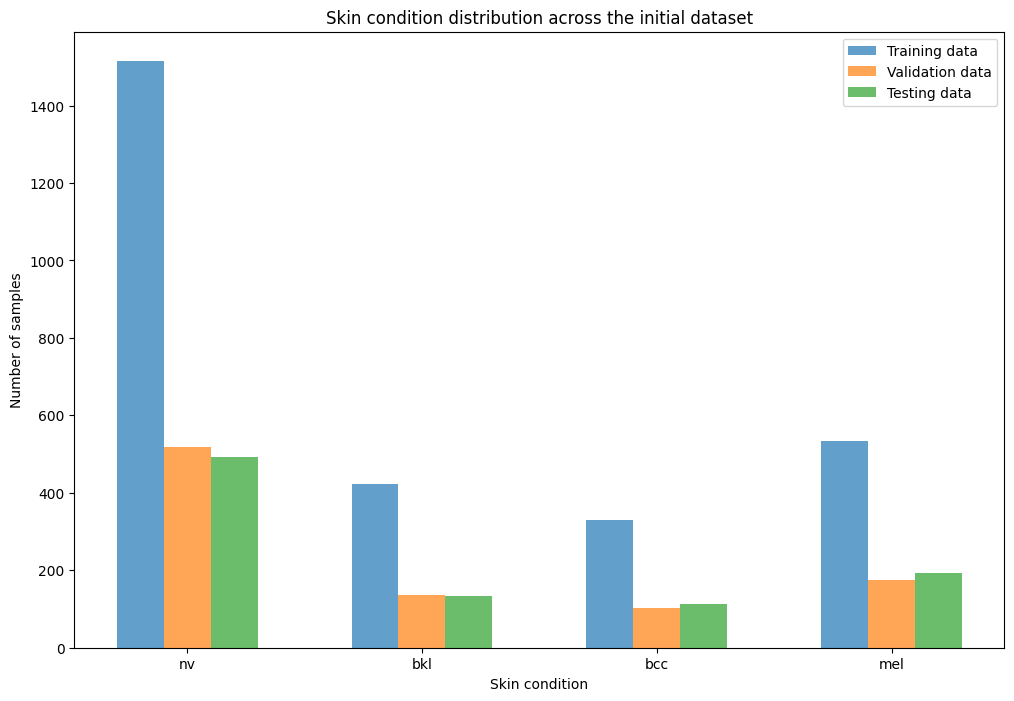

In [57]:
# Pre data augmentation 
labels = ['nv', 'bkl', 'bcc', 'mel']

def plot(train_counts, val_counts, test_counts, title):
    conditions = train_counts.keys()

    train_values = [train_counts.get(c, 0) for c in conditions]
    val_values = [val_counts.get(c, 0) for c in conditions]
    test_values = [test_counts.get(c, 0) for c in conditions]
    
    x = np.arange(len(conditions))
    width = 0.2 
    
    plt.figure(figsize=(12, 8))
    plt.bar(x - width, train_values, width, label='Training data', alpha=0.7)
    plt.bar(x, val_values, width, label='Validation data', alpha=0.7)
    plt.bar(x + width, test_values, width, label='Testing data', alpha=0.7)
    
    plt.xlabel('Skin condition')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(x, labels) # can confirm with swapping out conditions here
    plt.legend()
    
    plt.show()


plot(train_counts, val_counts, test_counts, "Skin condition distribution across the initial dataset")


In [58]:
conditions = train_counts.keys()
t_counts = [train_counts.get(c, 0) for c in conditions]
print(f"Training counts: {t_counts}")
v_counts = [val_counts.get(c, 0) for c in conditions]
print(f"Val counts: {v_counts}")
te_counts = [test_counts.get(c, 0) for c in conditions]
print(f"Test counts: {te_counts}")

Training counts: [1515, 423, 329, 534]
Val counts: [519, 137, 102, 175]
Test counts: [493, 133, 113, 194]


In [59]:
def augment(data, counts):
    max_count = max(counts)
    augments = [max_count - c for c in counts]

    # transforms for augmentation
    horiz = transforms.RandomHorizontalFlip()
    vert = transforms.RandomVerticalFlip()
    rot = transforms.RandomRotation(90)
    rot_1 = transforms.RandomRotation(270)

    
    augmented_data = []
    all_images = {i: [] for i in range(0, 3)}

    for img, label in data: 
        if label in range(0,3): # minority classes have labels 0, 1, 2
            all_images[label].append((img, label))

    for i in range(0, 3):
        images = all_images[i]
        
        for img, label in images:
            if augments[i + 1] <= 5: # initial class is majority class
                break
            augmented_data.append((horiz(img), label))
            augmented_data.append((vert(img), label))
            augmented_data.append((rot(img), label)) 
            augmented_data.append((rot_1(img), label))
            augments[i + 1] -= 4
            counts[i + 1] += 4
    
    full = data + augmented_data
    return full, counts

In [60]:
aug_test, test_counts = augment(test_data, te_counts)
aug_val, val_counts = augment(val_data, v_counts)
aug_train, train_counts = augment(train_data, t_counts)

In [61]:
train_loader = torch.utils.data.DataLoader(aug_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(aug_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(aug_test, shuffle=True)

In [62]:
# convert list to dict for visualization
def list_to_dict(counts):
    return {0: counts[1], 1: counts[2], 2: counts[3], 3: counts[0]}

test_dict = list_to_dict(test_counts)
val_dict = list_to_dict(val_counts)
train_dict = list_to_dict(train_counts)

In [75]:
train_counts_1 = get_counts(train_loader) # can confirm results with counter
val_counts_1 = get_counts(val_loader)
test_counts_1 = get_counts(test_loader)

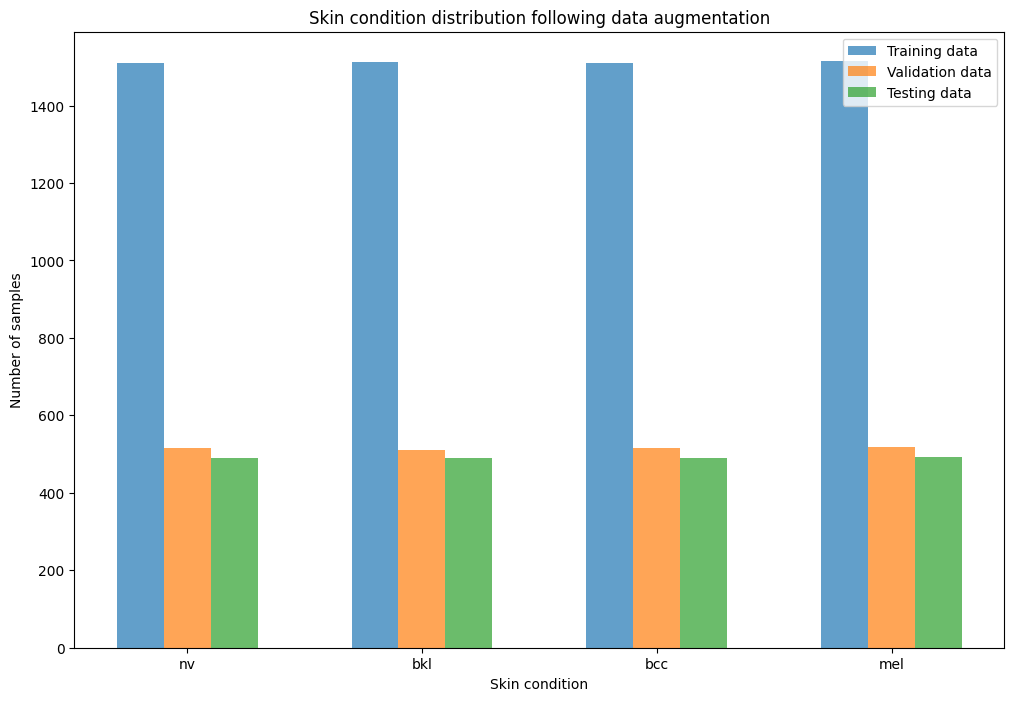

In [63]:
plot(train_dict, val_dict, test_dict, "Skin condition distribution following data augmentation")

# Model

In [37]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [76]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32 * 7 * 7, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [46]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


train_features, val_features, test_features = [], [], []

# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-2])
model.eval()  # Set model to evaluation mode

def get_features(loader, save):
    for imgs, labels in loader:
        with torch.no_grad():
            features = model(imgs)  # Shape: [batch_size, 512, 7, 7]
        save.append([features, labels])

# Example usage with train_loader, val_loader, test_loader
get_features(train_loader, train_features)
get_features(val_loader, val_features)
get_features(test_loader, test_features)


Using cache found in /Users/endothermiic/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature, label = self.features[idx]
        return feature.squeeze(), label

train_dataset = FeatureDataset(train_features)
val_dataset = FeatureDataset(val_features)
test_dataset = FeatureDataset(test_features)

In [19]:
def get_accuracy(model, data, batch_size):
    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1,keepdim = True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [41]:
def train(model, data, val_data=None, trial_num=0, batch_size=1, lr=0.01, num_epochs=10):
    torch.manual_seed(1000)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for imgs, labels in val_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            v_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy


        val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
        val_loss.append(float(v_loss)/batch_size)
        n += 1


        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

## 3500 imags, imbalanced

Epoch 1: Train acc: 0.5449871465295629 | Validation acc: 0.5312767780634104
Epoch 2: Train acc: 0.5886889460154242 | Validation acc: 0.5664095972579263
Epoch 3: Train acc: 0.6386746643816053 | Validation acc: 0.5989717223650386
Epoch 4: Train acc: 0.6818051985147101 | Validation acc: 0.6461011139674379
Epoch 5: Train acc: 0.7023707512139389 | Validation acc: 0.6486718080548415
Epoch 6: Train acc: 0.731505284204513 | Validation acc: 0.6700942587832048
Epoch 7: Train acc: 0.7435018566123964 | Validation acc: 0.6486718080548415
Epoch 8: Train acc: 0.7757783490431306 | Validation acc: 0.6700942587832048
Epoch 9: Train acc: 0.8046272493573264 | Validation acc: 0.676949443016281
Epoch 10: Train acc: 0.8400457012282205 | Validation acc: 0.6700942587832048
Epoch 11: Train acc: 0.8708940302770637 | Validation acc: 0.6889460154241646
Epoch 12: Train acc: 0.8837475007140817 | Validation acc: 0.6743787489288775
Epoch 13: Train acc: 0.9200228506141103 | Validation acc: 0.6786632390745502
Epoch 14: 

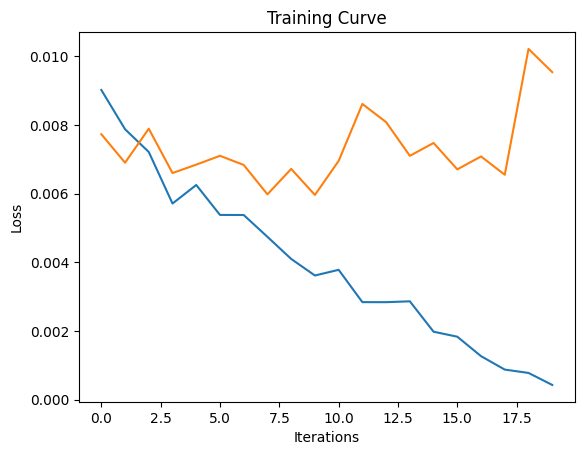

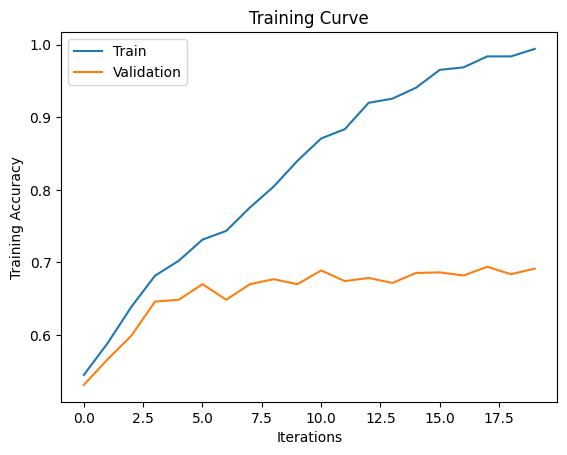

Final Training Accuracy: 0.9942873464724364
Final Validation Accuracy: 0.6915167095115681


In [26]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=20)

Epoch 1: Train acc: 0.5287060839760068 | Validation acc: 0.5261353898886033
Epoch 2: Train acc: 0.5478434732933447 | Validation acc: 0.5278491859468724
Epoch 3: Train acc: 0.548129105969723 | Validation acc: 0.5338474721508141
Epoch 4: Train acc: 0.5478434732933447 | Validation acc: 0.5389888603256212
Epoch 5: Train acc: 0.5506998000571265 | Validation acc: 0.5389888603256212
Epoch 6: Train acc: 0.5541273921736647 | Validation acc: 0.5355612682090831
Epoch 7: Train acc: 0.5615538417594973 | Validation acc: 0.5484147386461011
Epoch 8: Train acc: 0.5686946586689517 | Validation acc: 0.5484147386461011
Epoch 9: Train acc: 0.5801199657240789 | Validation acc: 0.5552699228791774
Epoch 10: Train acc: 0.5904027420736933 | Validation acc: 0.5689802913453299
Epoch 11: Train acc: 0.609254498714653 | Validation acc: 0.5938303341902313
Epoch 12: Train acc: 0.6218223364752927 | Validation acc: 0.5955441302485004
Epoch 13: Train acc: 0.6326763781776635 | Validation acc: 0.6083976006855184
Epoch 14: 

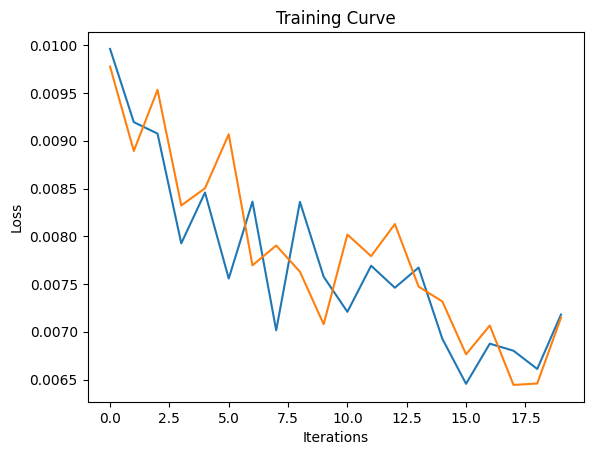

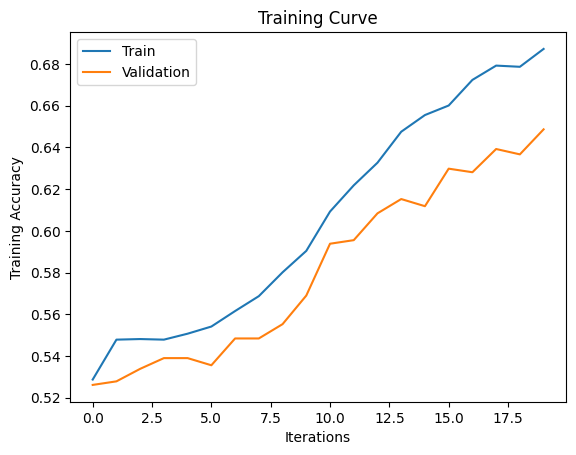

Final Training Accuracy: 0.6872322193658955
Final Validation Accuracy: 0.6486718080548415


In [27]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.6338189088831763 | Validation acc: 0.6015424164524421
Epoch 2: Train acc: 0.6966580976863753 | Validation acc: 0.6401028277634961
Epoch 3: Train acc: 0.7257926306769494 | Validation acc: 0.6443873179091688
Epoch 4: Train acc: 0.7563553270494144 | Validation acc: 0.662382176520994
Epoch 5: Train acc: 0.7709225935447015 | Validation acc: 0.6495287060839761
Epoch 6: Train acc: 0.8274778634675807 | Validation acc: 0.6589545844044559
Epoch 7: Train acc: 0.8477577834904313 | Validation acc: 0.6418166238217652
Epoch 8: Train acc: 0.8660382747786347 | Validation acc: 0.6461011139674379
Epoch 9: Train acc: 0.8997429305912596 | Validation acc: 0.6700942587832048
Epoch 10: Train acc: 0.9154527277920594 | Validation acc: 0.6632390745501285
Total time elapsed: 86.49 s


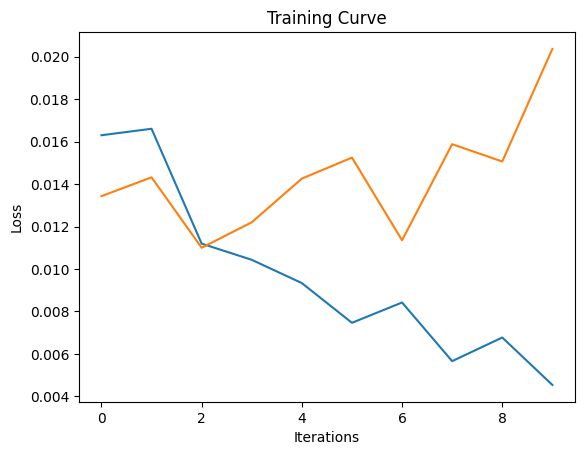

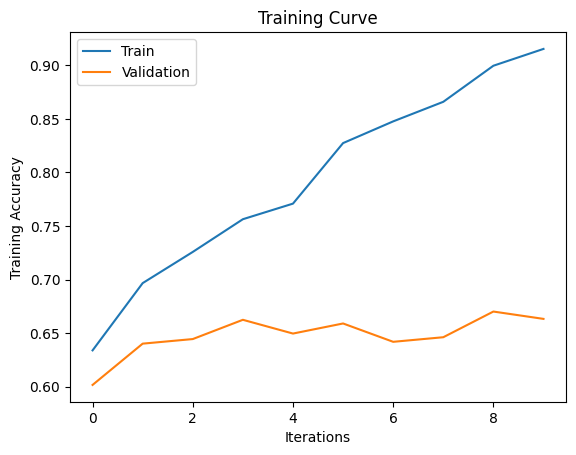

Final Training Accuracy: 0.9154527277920594
Final Validation Accuracy: 0.6632390745501285


In [28]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5467009425878321 | Validation acc: 0.5287060839760068
Epoch 2: Train acc: 0.5484147386461011 | Validation acc: 0.5304198800342759
Epoch 3: Train acc: 0.5558411882319337 | Validation acc: 0.5398457583547558
Epoch 4: Train acc: 0.5632676378177663 | Validation acc: 0.5492716366752356
Epoch 5: Train acc: 0.5912596401028277 | Validation acc: 0.5621251071122536
Epoch 6: Train acc: 0.614110254213082 | Validation acc: 0.586975149957155
Epoch 7: Train acc: 0.639817195087118 | Validation acc: 0.5904027420736933
Epoch 8: Train acc: 0.6489574407312196 | Validation acc: 0.6058269065981148
Epoch 9: Train acc: 0.6629534418737504 | Validation acc: 0.6135389888603257
Epoch 10: Train acc: 0.6669522993430449 | Validation acc: 0.6118251928020566
Total time elapsed: 93.19 s


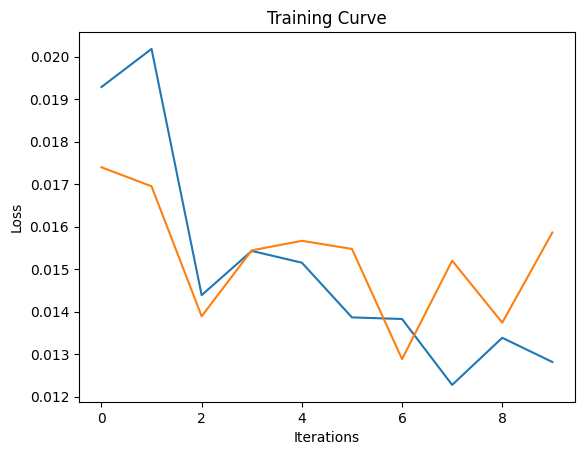

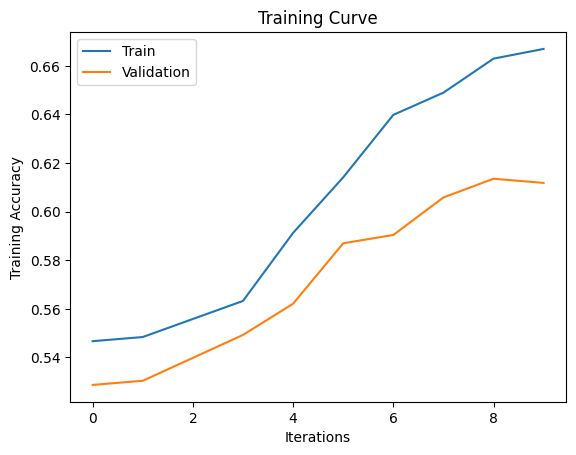

Final Training Accuracy: 0.6669522993430449
Final Validation Accuracy: 0.6118251928020566


In [29]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

In [30]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=64, lr=0.0004, num_epochs=50)

Epoch 1: Train acc: 0.554698657526421 | Validation acc: 0.5398457583547558
Epoch 2: Train acc: 0.6155384175949729 | Validation acc: 0.5861182519280206
Epoch 3: Train acc: 0.6755212796343901 | Validation acc: 0.6246786632390745
Epoch 4: Train acc: 0.6986575264210225 | Validation acc: 0.6580976863753213
Epoch 5: Train acc: 0.7160811196800914 | Validation acc: 0.6640959725792631
Epoch 6: Train acc: 0.7329334475864039 | Validation acc: 0.6692373607540703
Epoch 7: Train acc: 0.7495001428163381 | Validation acc: 0.6675235646958012
Epoch 8: Train acc: 0.7714938588974579 | Validation acc: 0.6632390745501285
Epoch 9: Train acc: 0.7946301056840903 | Validation acc: 0.6649528706083976
Epoch 10: Train acc: 0.808626106826621 | Validation acc: 0.6615252784918595
Epoch 11: Train acc: 0.821479577263639 | Validation acc: 0.6598114824335904
Epoch 12: Train acc: 0.8577549271636675 | Validation acc: 0.6649528706083976
Epoch 13: Train acc: 0.8757497857754927 | Validation acc: 0.6632390745501285
Epoch 14: T

KeyboardInterrupt: 

Epoch 1: Train acc: 0.5518423307626392 | Validation acc: 0.5389888603256212
Epoch 2: Train acc: 0.56583833190517 | Validation acc: 0.5389888603256212
Epoch 3: Train acc: 0.5812624964295915 | Validation acc: 0.5604113110539846
Epoch 4: Train acc: 0.5892602113681805 | Validation acc: 0.5732647814910026
Epoch 5: Train acc: 0.6072550699800057 | Validation acc: 0.5715509854327335
Epoch 6: Train acc: 0.6212510711225364 | Validation acc: 0.586975149957155
Epoch 7: Train acc: 0.6392459297343616 | Validation acc: 0.6023993144815767
Epoch 8: Train acc: 0.6523850328477577 | Validation acc: 0.6203941730934018
Epoch 9: Train acc: 0.6698086261068266 | Validation acc: 0.6178234790059983
Epoch 10: Train acc: 0.6923736075407027 | Validation acc: 0.6323907455012854
Total time elapsed: 115.18 s


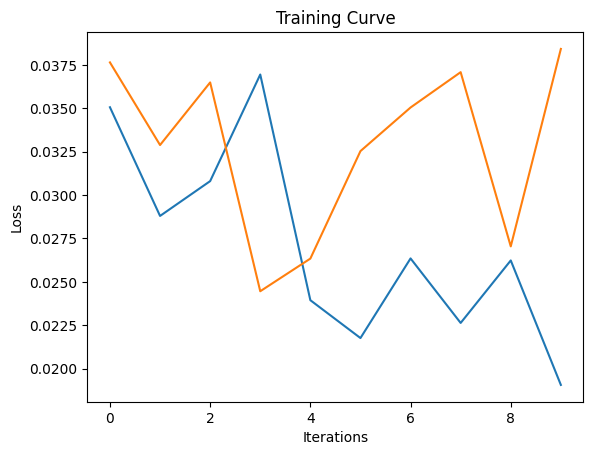

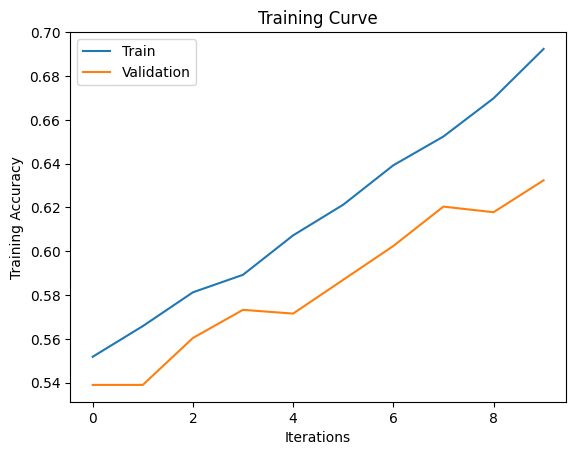

Final Training Accuracy: 0.6923736075407027
Final Validation Accuracy: 0.6323907455012854


In [32]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=32, lr=0.0001, num_epochs=10)

In [33]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=16, lr=0.0001, num_epochs=40)

Epoch 1: Train acc: 0.5452727792059412 | Validation acc: 0.5329905741216795
Epoch 2: Train acc: 0.598114824335904 | Validation acc: 0.585261353898886
Epoch 3: Train acc: 0.6600971151099686 | Validation acc: 0.6358183376178235
Epoch 4: Train acc: 0.6795201371036846 | Validation acc: 0.6426735218508998
Epoch 5: Train acc: 0.7080834047415024 | Validation acc: 0.6520994001713796
Epoch 6: Train acc: 0.7249357326478149 | Validation acc: 0.6520994001713796
Epoch 7: Train acc: 0.7489288774635818 | Validation acc: 0.662382176520994
Epoch 8: Train acc: 0.7743501856612397 | Validation acc: 0.6700942587832048
Epoch 9: Train acc: 0.7917737789203085 | Validation acc: 0.6606683804627249
Epoch 10: Train acc: 0.8226221079691517 | Validation acc: 0.6658097686375322
Epoch 11: Train acc: 0.8449014567266495 | Validation acc: 0.6692373607540703
Epoch 12: Train acc: 0.8723221936589546 | Validation acc: 0.6563838903170522
Epoch 13: Train acc: 0.8863181948014853 | Validation acc: 0.6563838903170522
Epoch 14: T

KeyboardInterrupt: 

Epoch 1: Train acc: 0.6069694373036275 | Validation acc: 0.5698371893744645
Epoch 2: Train acc: 0.689802913453299 | Validation acc: 0.6435304198800342
Epoch 3: Train acc: 0.7280776920879749 | Validation acc: 0.6580976863753213
Epoch 4: Train acc: 0.7566409597257926 | Validation acc: 0.6649528706083976
Epoch 5: Train acc: 0.8031990859754355 | Validation acc: 0.6486718080548415
Epoch 6: Train acc: 0.8277634961439588 | Validation acc: 0.6580976863753213
Epoch 7: Train acc: 0.8346186803770351 | Validation acc: 0.6735218508997429
Epoch 8: Train acc: 0.8634675806912311 | Validation acc: 0.6572407883461868
Epoch 9: Train acc: 0.8863181948014853 | Validation acc: 0.6572407883461868
Epoch 10: Train acc: 0.9108826049700086 | Validation acc: 0.6529562982005142
Total time elapsed: 110.96 s


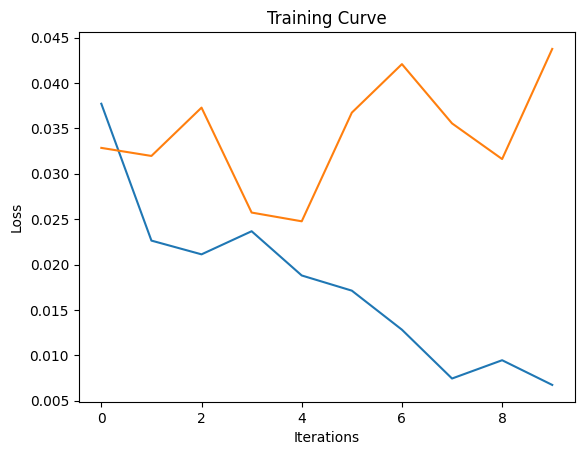

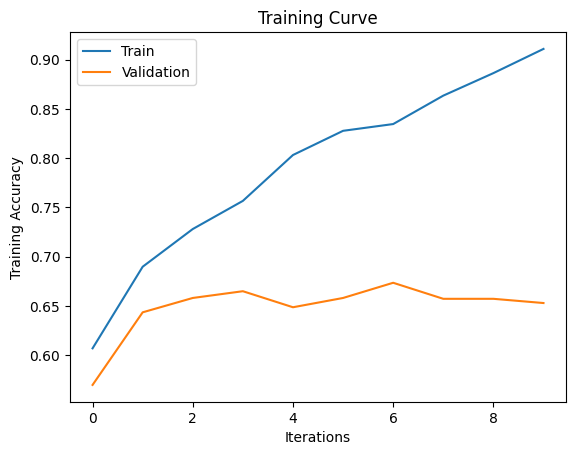

Final Training Accuracy: 0.9108826049700086
Final Validation Accuracy: 0.6529562982005142


In [42]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=10)

## 7000 images, imbalanced

Epoch 1: Train acc: 0.5730401256604313 | Validation acc: 0.5801199657240789
Epoch 2: Train acc: 0.6667142653148651 | Validation acc: 0.6692373607540703
Epoch 3: Train acc: 0.699557332571755 | Validation acc: 0.6782347900599829
Epoch 4: Train acc: 0.7288305012137656 | Validation acc: 0.6928020565552699
Epoch 5: Train acc: 0.7379694416678566 | Validation acc: 0.7060839760068551
Epoch 6: Train acc: 0.776952734542339 | Validation acc: 0.7065124250214224
Epoch 7: Train acc: 0.8030843924032558 | Validation acc: 0.7022279348757497
Epoch 8: Train acc: 0.8336427245466229 | Validation acc: 0.7086546700942588
Epoch 9: Train acc: 0.8526345851777809 | Validation acc: 0.7146529562982005
Epoch 10: Train acc: 0.87248322147651 | Validation acc: 0.7116538131962297
Total time elapsed: 185.68 s


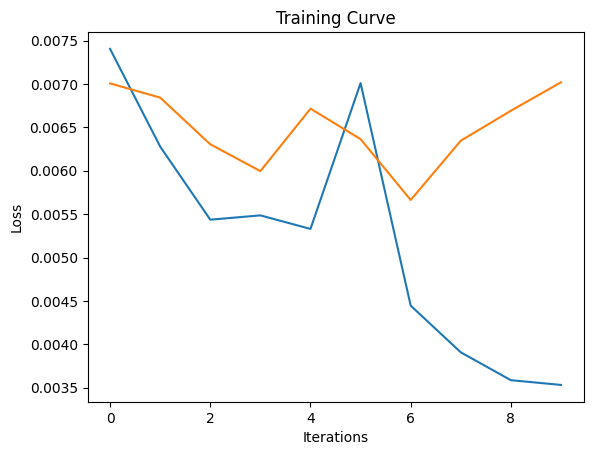

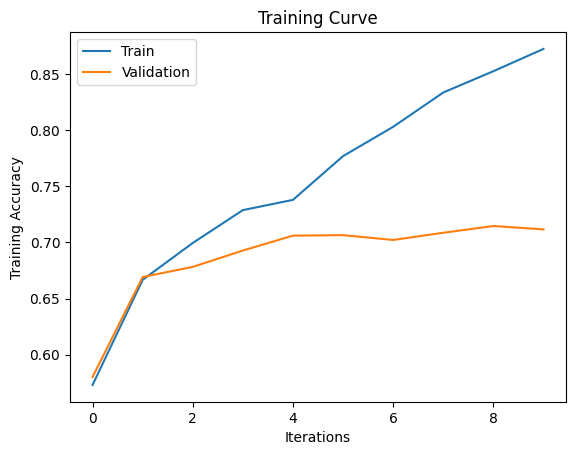

Final Training Accuracy: 0.87248322147651
Final Validation Accuracy: 0.7116538131962297


In [48]:
model_cnn_2 = CNNClassifier() # 7000 training images
train(model_cnn_2, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6701413679851492 | Validation acc: 0.6645244215938303
Epoch 2: Train acc: 0.7072683135798943 | Validation acc: 0.6803770351328192
Epoch 3: Train acc: 0.7488219334570898 | Validation acc: 0.6983718937446444
Epoch 4: Train acc: 0.7750963872626018 | Validation acc: 0.7103684661525278
Epoch 5: Train acc: 0.8033699842924461 | Validation acc: 0.7180805484147387
Epoch 6: Train acc: 0.8330715407682422 | Validation acc: 0.7069408740359897
Epoch 7: Train acc: 0.8653434242467514 | Validation acc: 0.7060839760068551
Epoch 8: Train acc: 0.8766243038697701 | Validation acc: 0.7030848329048843
Epoch 9: Train acc: 0.8994716550049978 | Validation acc: 0.7035132819194516
Epoch 10: Train acc: 0.9143224332428959 | Validation acc: 0.7043701799485861
Total time elapsed: 166.55 s


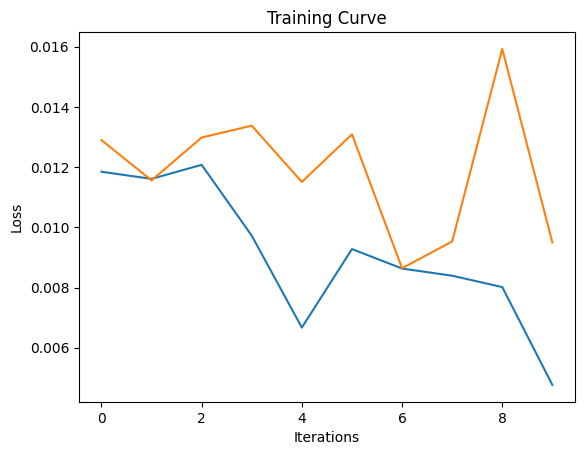

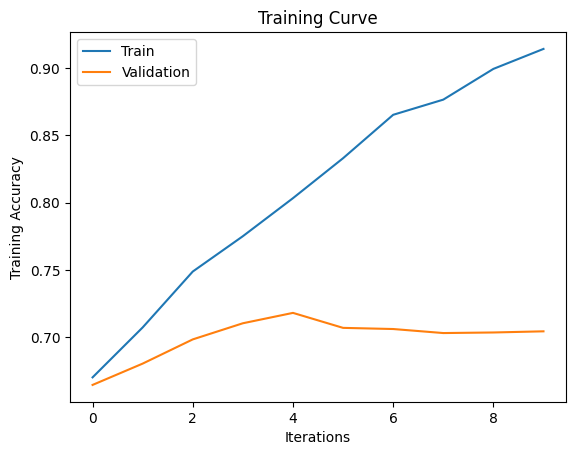

Final Training Accuracy: 0.9143224332428959
Final Validation Accuracy: 0.7043701799485861


In [49]:
model_cnn_2 = CNNClassifier() # 7000 training images
train(model_cnn_2, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5454805083535628 | Validation acc: 0.5574121679520138
Epoch 2: Train acc: 0.5471940596887048 | Validation acc: 0.5651242502142245
Epoch 3: Train acc: 0.5683278594887905 | Validation acc: 0.583547557840617
Epoch 4: Train acc: 0.5908896187348279 | Validation acc: 0.5976863753213367
Epoch 5: Train acc: 0.6118806225903184 | Validation acc: 0.6251071122536418
Epoch 6: Train acc: 0.6317292588890475 | Validation acc: 0.6383890317052271
Epoch 7: Train acc: 0.648579180351278 | Validation acc: 0.6628106255355612
Epoch 8: Train acc: 0.6597172640297015 | Validation acc: 0.6675235646958012
Epoch 9: Train acc: 0.6721405112094817 | Validation acc: 0.6795201371036846
Epoch 10: Train acc: 0.6825646151649293 | Validation acc: 0.6765209940017138
Total time elapsed: 183.05 s


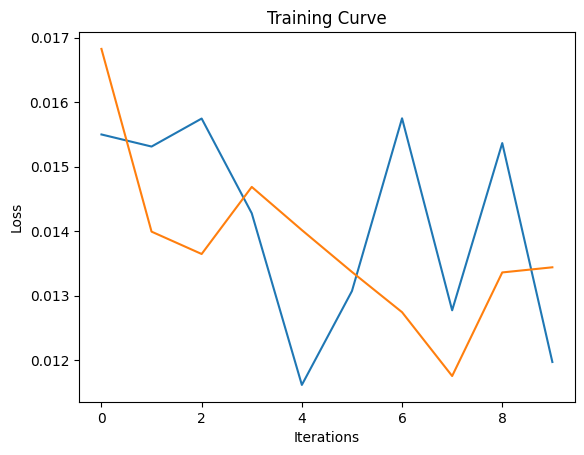

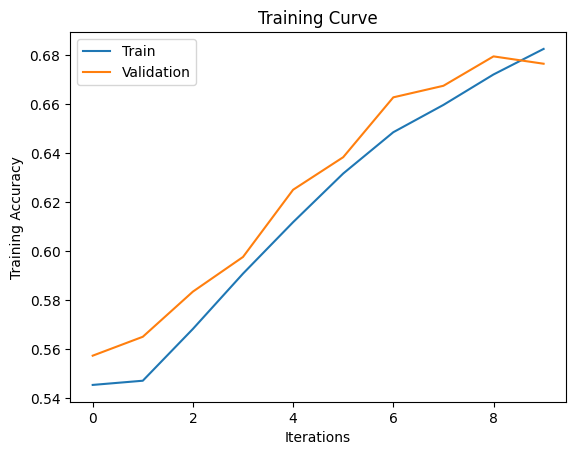

Final Training Accuracy: 0.6825646151649293
Final Validation Accuracy: 0.6765209940017138


In [51]:
model_cnn_2 = CNNClassifier() # 7000 training images
train(model_cnn_2, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

## 7000, even split

Epoch 1: Train acc: 0.5424817935170642 | Validation acc: 0.5578406169665809
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5599828620394173
Epoch 3: Train acc: 0.5439097529630158 | Validation acc: 0.5612682090831191
Epoch 4: Train acc: 0.5497643866914179 | Validation acc: 0.5655526992287918
Epoch 5: Train acc: 0.5617592460374126 | Validation acc: 0.5745501285347043
Epoch 6: Train acc: 0.583464229615879 | Validation acc: 0.6023993144815767
Epoch 7: Train acc: 0.5936027416821362 | Validation acc: 0.6036846615252784
Epoch 8: Train acc: 0.6141653577038412 | Validation acc: 0.62382176520994
Epoch 9: Train acc: 0.6293017278309296 | Validation acc: 0.6345329905741217
Epoch 10: Train acc: 0.6348707696701413 | Validation acc: 0.6448157669237361
Total time elapsed: 206.75 s


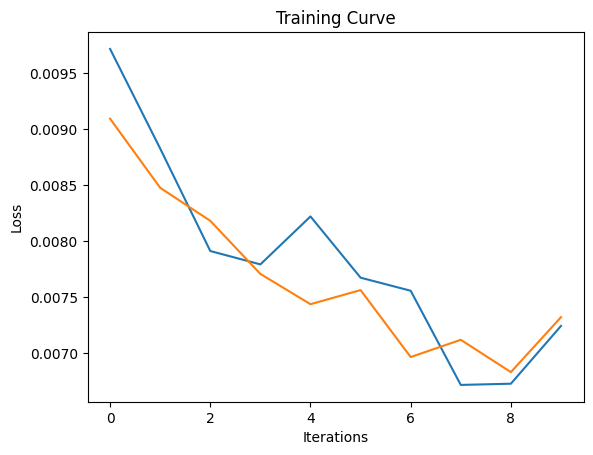

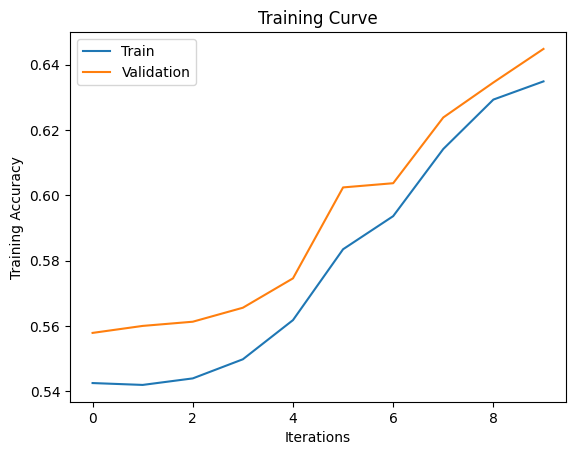

Final Training Accuracy: 0.6348707696701413
Final Validation Accuracy: 0.6448157669237361


In [64]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=10)

In [65]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=20)

Epoch 1: Train acc: 0.5469084677995145 | Validation acc: 0.5638389031705227
Epoch 2: Train acc: 0.6273025846065972 | Validation acc: 0.6328191945158527
Epoch 3: Train acc: 0.6631443666999857 | Validation acc: 0.6666666666666666
Epoch 4: Train acc: 0.6862773097244038 | Validation acc: 0.6730934018851756
Epoch 5: Train acc: 0.7035556190204199 | Validation acc: 0.6842330762639246
Epoch 6: Train acc: 0.7135513351420819 | Validation acc: 0.6863753213367609
Epoch 7: Train acc: 0.7256889904326718 | Validation acc: 0.6949443016281063
Epoch 8: Train acc: 0.7439668713408539 | Validation acc: 0.6958011996572407
Epoch 9: Train acc: 0.7631015279166071 | Validation acc: 0.7052270779777207
Epoch 10: Train acc: 0.7786662858774811 | Validation acc: 0.709083119108826
Epoch 11: Train acc: 0.7970869627302585 | Validation acc: 0.7095115681233933


KeyboardInterrupt: 

In [66]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5857489647294016 | Validation acc: 0.6053984575835476
Epoch 2: Train acc: 0.669998572040554 | Validation acc: 0.6658097686375322
Epoch 3: Train acc: 0.709410252748822 | Validation acc: 0.6863753213367609
Epoch 4: Train acc: 0.7324003998286449 | Validation acc: 0.6872322193658955
Epoch 5: Train acc: 0.7505354847922319 | Validation acc: 0.7030848329048843
Epoch 6: Train acc: 0.7885192060545481 | Validation acc: 0.7180805484147387
Epoch 7: Train acc: 0.8176495787519634 | Validation acc: 0.709083119108826
Epoch 8: Train acc: 0.8384977866628588 | Validation acc: 0.7052270779777207


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5419106097386834 | Validation acc: 0.5591259640102828
Epoch 2: Train acc: 0.5420534056832786 | Validation acc: 0.5612682090831191
Epoch 3: Train acc: 0.5569041839211767 | Validation acc: 0.5758354755784062
Epoch 4: Train acc: 0.5896044552334714 | Validation acc: 0.6058269065981148
Epoch 5: Train acc: 0.6208767670998143 | Validation acc: 0.6379605826906598
Epoch 6: Train acc: 0.6478652006283021 | Validation acc: 0.6568123393316195
Epoch 7: Train acc: 0.6600028559188919 | Validation acc: 0.6645244215938303
Epoch 8: Train acc: 0.6728544909324575 | Validation acc: 0.6760925449871465
Epoch 9: Train acc: 0.6878480651149508 | Validation acc: 0.6765209940017138
Epoch 10: Train acc: 0.6988433528487791 | Validation acc: 0.6812339331619537
Total time elapsed: 431.55 s


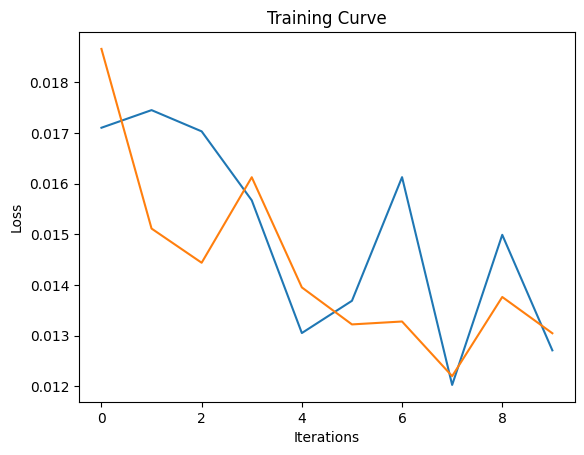

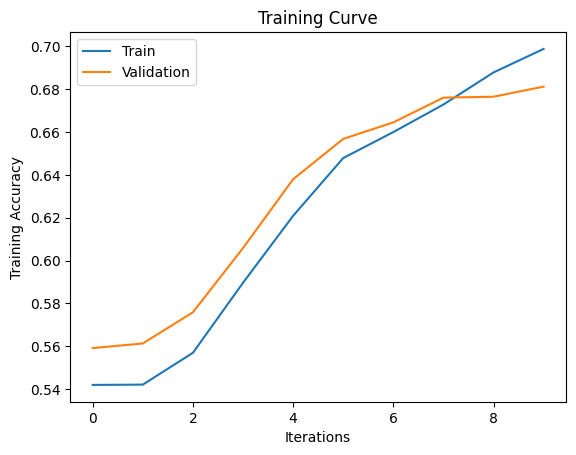

Final Training Accuracy: 0.6988433528487791
Final Validation Accuracy: 0.6812339331619537


In [67]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

In [68]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=64, lr=0.0005, num_epochs=40)

Epoch 1: Train acc: 0.5956018849064687 | Validation acc: 0.6079691516709511
Epoch 2: Train acc: 0.6841353705554762 | Validation acc: 0.6782347900599829
Epoch 3: Train acc: 0.7138369270312723 | Validation acc: 0.6915167095115681
Epoch 4: Train acc: 0.7388262173354276 | Validation acc: 0.6966580976863753
Epoch 5: Train acc: 0.7718120805369127 | Validation acc: 0.7146529562982005
Epoch 6: Train acc: 0.7842353277166928 | Validation acc: 0.7039417309340189
Epoch 7: Train acc: 0.824646580037127 | Validation acc: 0.7176520994001714
Epoch 8: Train acc: 0.8440668285020705 | Validation acc: 0.7082262210796915


KeyboardInterrupt: 

Epoch 1: Train acc: 0.6091674996430101 | Validation acc: 0.6182519280205655
Epoch 2: Train acc: 0.682279023275739 | Validation acc: 0.6825192802056556
Epoch 3: Train acc: 0.7065543338569185 | Validation acc: 0.6885175664095973
Epoch 4: Train acc: 0.7425389118949022 | Validation acc: 0.7167952013710368
Epoch 5: Train acc: 0.7606739968584892 | Validation acc: 0.7253641816623821
Epoch 6: Train acc: 0.7788090818220762 | Validation acc: 0.7262210796915167
Epoch 7: Train acc: 0.8062259031843496 | Validation acc: 0.721936589545844
Epoch 8: Train acc: 0.8240753962587463 | Validation acc: 0.7133676092544987
Epoch 9: Train acc: 0.8487790946737113 | Validation acc: 0.7249357326478149
Epoch 10: Train acc: 0.8649150364129659 | Validation acc: 0.7146529562982005
Total time elapsed: 219.98 s


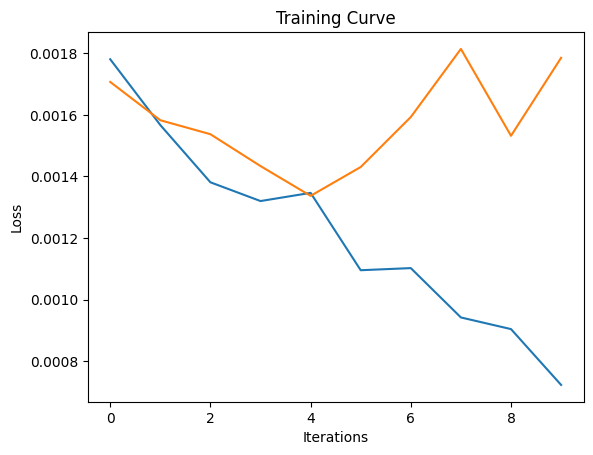

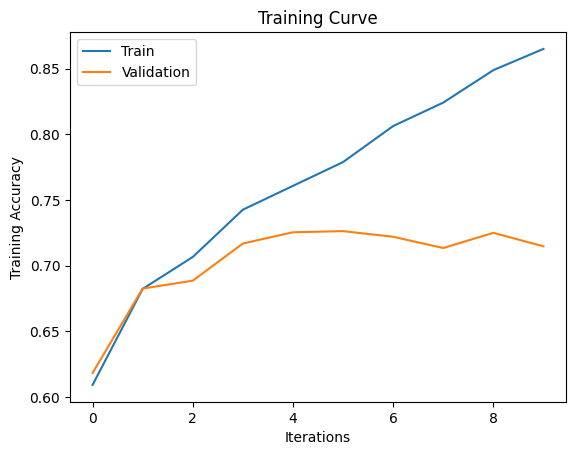

Final Training Accuracy: 0.8649150364129659
Final Validation Accuracy: 0.7146529562982005


In [69]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=512, lr=0.05, num_epochs=10)

Epoch 1: Train acc: 0.6704269598743395 | Validation acc: 0.6658097686375322
Epoch 2: Train acc: 0.7196915607596744 | Validation acc: 0.7146529562982005
Epoch 3: Train acc: 0.748107953734114 | Validation acc: 0.7253641816623821
Epoch 4: Train acc: 0.7613879765814651 | Validation acc: 0.715509854327335
Epoch 5: Train acc: 0.7936598600599742 | Validation acc: 0.7279348757497858
Epoch 6: Train acc: 0.7829501642153363 | Validation acc: 0.6940874035989717
Epoch 7: Train acc: 0.8287876624303869 | Validation acc: 0.709083119108826
Epoch 8: Train acc: 0.8494930743966871 | Validation acc: 0.7283633247643531
Epoch 9: Train acc: 0.8597743824075397 | Validation acc: 0.7240788346186804
Epoch 10: Train acc: 0.8676281593602742 | Validation acc: 0.7043701799485861
Total time elapsed: 183.86 s


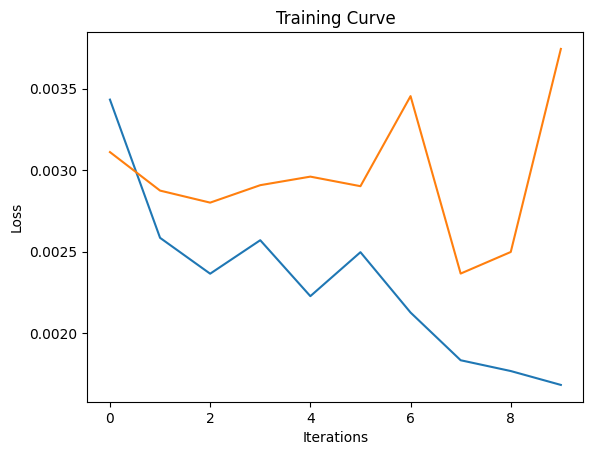

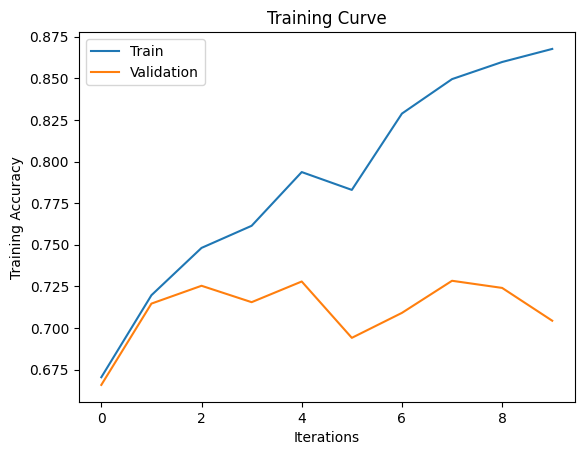

Final Training Accuracy: 0.8676281593602742
Final Validation Accuracy: 0.7043701799485861


In [70]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=256, lr=0.05, num_epochs=10)

Epoch 1: Train acc: 0.6150221333714122 | Validation acc: 0.6281062553556127
Epoch 2: Train acc: 0.6959874339568757 | Validation acc: 0.6936589545844044
Epoch 3: Train acc: 0.7175496215907469 | Validation acc: 0.6936589545844044
Epoch 4: Train acc: 0.7478223618449236 | Validation acc: 0.7206512425021423
Epoch 5: Train acc: 0.7849493074396687 | Validation acc: 0.7322193658954584
Epoch 6: Train acc: 0.8012280451235185 | Validation acc: 0.7125107112253641
Epoch 7: Train acc: 0.8349278880479795 | Validation acc: 0.718508997429306
Epoch 8: Train acc: 0.8409253177209767 | Validation acc: 0.7129391602399314
Epoch 9: Train acc: 0.8726260174211052 | Validation acc: 0.7142245072836333
Epoch 10: Train acc: 0.9008996144509496 | Validation acc: 0.715509854327335
Total time elapsed: 196.68 s


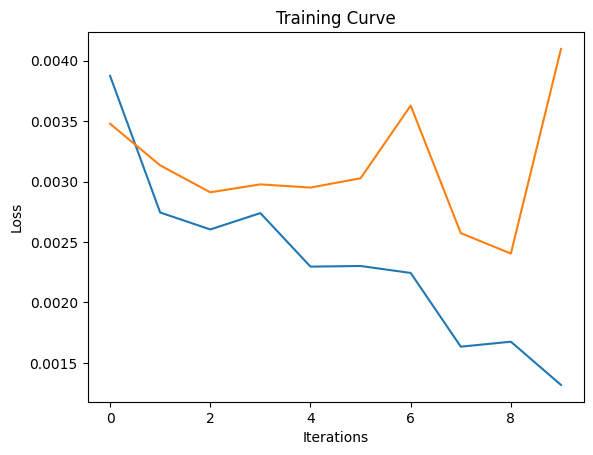

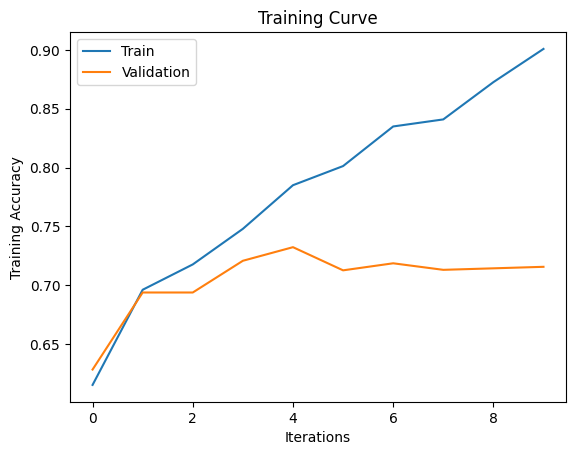

Final Training Accuracy: 0.9008996144509496
Final Validation Accuracy: 0.715509854327335


In [71]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=256, lr=0.005, num_epochs=10)

Epoch 1: Train acc: 0.671569327431101 | Validation acc: 0.6726649528706083
Epoch 2: Train acc: 0.7229758674853635 | Validation acc: 0.7077977720651243
Epoch 3: Train acc: 0.7445380551192347 | Validation acc: 0.7086546700942588
Epoch 4: Train acc: 0.7772383264315293 | Validation acc: 0.7193658954584404
Epoch 5: Train acc: 0.8062259031843496 | Validation acc: 0.7227934875749786
Epoch 6: Train acc: 0.8265029273168643 | Validation acc: 0.712082262210797
Epoch 7: Train acc: 0.8524917892331858 | Validation acc: 0.7107969151670951
Epoch 8: Train acc: 0.8669141796372983 | Validation acc: 0.7240788346186804
Epoch 9: Train acc: 0.8509210338426388 | Validation acc: 0.7163667523564696
Epoch 10: Train acc: 0.8956161645009282 | Validation acc: 0.7339331619537275
Total time elapsed: 233.90 s


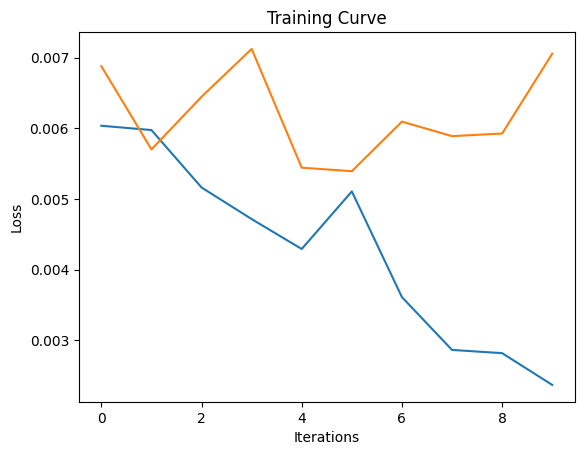

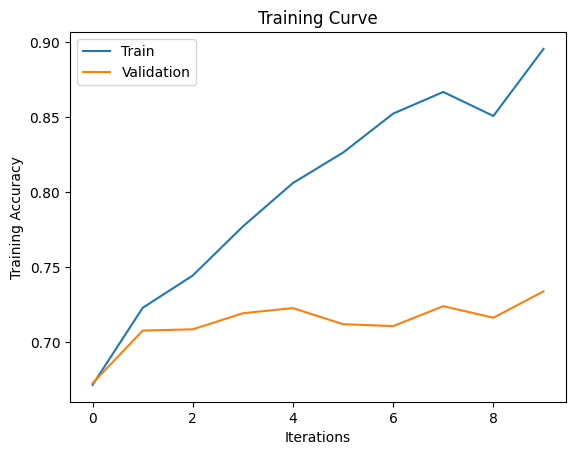

Final Training Accuracy: 0.8956161645009282
Final Validation Accuracy: 0.7339331619537275


In [73]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=128, lr=0.005, num_epochs=10)

Epoch 1: Train acc: 0.6898472083392831 | Validation acc: 0.6675235646958012
Epoch 2: Train acc: 0.7408253605597601 | Validation acc: 0.7107969151670951
Epoch 3: Train acc: 0.7649578751963444 | Validation acc: 0.7022279348757497
Epoch 4: Train acc: 0.7788090818220762 | Validation acc: 0.7082262210796915
Epoch 5: Train acc: 0.8069398829073254 | Validation acc: 0.7257926306769494
Epoch 6: Train acc: 0.8446380122804512 | Validation acc: 0.7060839760068551
Epoch 7: Train acc: 0.843638440668285 | Validation acc: 0.68808911739503
Epoch 8: Train acc: 0.8681993431386549 | Validation acc: 0.7167952013710368
Epoch 9: Train acc: 0.8984720833928317 | Validation acc: 0.7227934875749786
Epoch 10: Train acc: 0.9181779237469656 | Validation acc: 0.718508997429306
Total time elapsed: 220.93 s


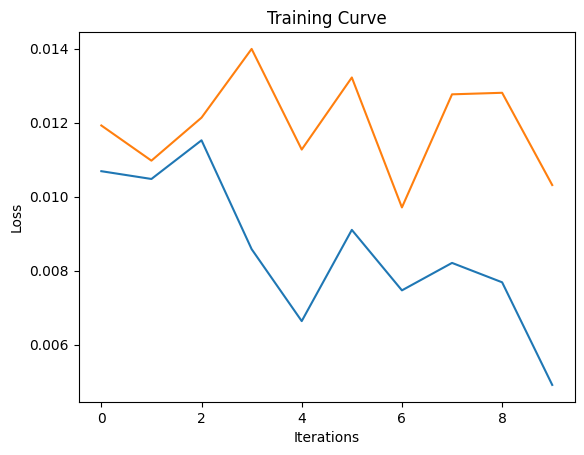

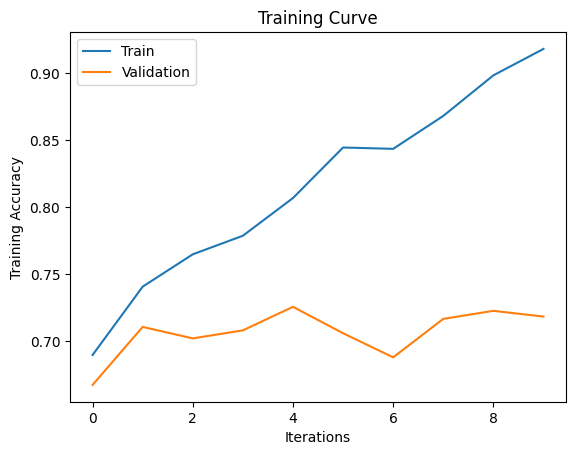

Final Training Accuracy: 0.9181779237469656
Final Validation Accuracy: 0.718508997429306


In [74]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=64, lr=0.005, num_epochs=10)

In [75]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=30)

Epoch 1: Train acc: 0.5426245894616593 | Validation acc: 0.5604113110539846
Epoch 2: Train acc: 0.54319577324004 | Validation acc: 0.5608397600685519
Epoch 3: Train acc: 0.5611880622590318 | Validation acc: 0.5762639245929735
Epoch 4: Train acc: 0.6044552334713694 | Validation acc: 0.615681233933162
Epoch 5: Train acc: 0.6348707696701413 | Validation acc: 0.6435304198800342
Epoch 6: Train acc: 0.6557189775810367 | Validation acc: 0.6653813196229649
Epoch 7: Train acc: 0.668285020705412 | Validation acc: 0.6700942587832048
Epoch 8: Train acc: 0.6848493502784521 | Validation acc: 0.6773778920308483
Epoch 9: Train acc: 0.6984149650149936 | Validation acc: 0.6808054841473865
Epoch 10: Train acc: 0.7026988433528488 | Validation acc: 0.6825192802056556
Epoch 11: Train acc: 0.7129801513637013 | Validation acc: 0.6859468723221936
Epoch 12: Train acc: 0.7198343567042697 | Validation acc: 0.6936589545844044
Epoch 13: Train acc: 0.7279737255461944 | Validation acc: 0.6966580976863753
Epoch 14: Tr

KeyboardInterrupt: 

In [99]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(288, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        x = self.pool(self.conv3(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch 1: Train acc: 0.5477652434670855 | Validation acc: 0.5711225364181662
Epoch 2: Train acc: 0.5444809367413965 | Validation acc: 0.5621251071122536
Epoch 3: Train acc: 0.5433385691846352 | Validation acc: 0.5625535561268209
Epoch 4: Train acc: 0.545623304298158 | Validation acc: 0.5625535561268209
Epoch 5: Train acc: 0.5551906325860345 | Validation acc: 0.5775492716366752
Epoch 6: Train acc: 0.5766100242753106 | Validation acc: 0.5912596401028277
Epoch 7: Train acc: 0.5974582321862059 | Validation acc: 0.6105398457583547
Epoch 8: Train acc: 0.6151649293160074 | Validation acc: 0.6306769494430163
Epoch 9: Train acc: 0.6342995858917607 | Validation acc: 0.6461011139674379
Epoch 10: Train acc: 0.6427245466228759 | Validation acc: 0.6563838903170522
Epoch 11: Train acc: 0.6607168356418678 | Validation acc: 0.6598114824335904
Epoch 12: Train acc: 0.6664286734256747 | Validation acc: 0.6670951156812339
Epoch 13: Train acc: 0.6718549193202913 | Validation acc: 0.6718080548414739
Epoch 14:

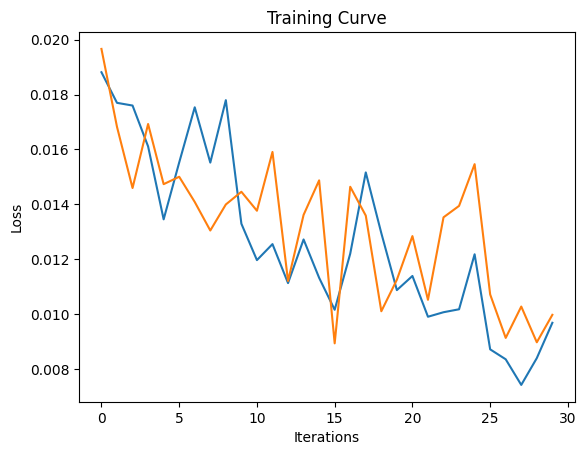

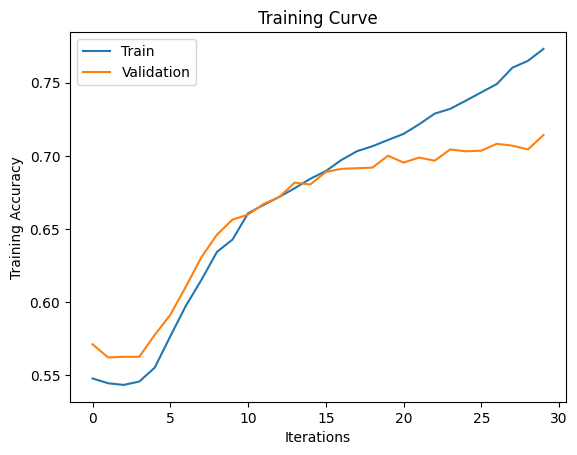

Final Training Accuracy: 0.7730972440382693
Final Validation Accuracy: 0.7142245072836333


In [97]:
model_cnn_4 = CNNClassifier() # 7000 training images
train(model_cnn_4, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=30)

In [100]:
model_cnn_4 = CNNClassifier() # 7000 training images
train(model_cnn_4, train_dataset, val_dataset, batch_size=256, lr=0.0001, num_epochs=30)

Epoch 1: Train acc: 0.22447522490361274 | Validation acc: 0.22236503856041132
Epoch 2: Train acc: 0.3501356561473654 | Validation acc: 0.36418166238217653
Epoch 3: Train acc: 0.4720833928316436 | Validation acc: 0.4781491002570694
Epoch 4: Train acc: 0.5229187491075253 | Validation acc: 0.5432733504712939
Epoch 5: Train acc: 0.5404826502927317 | Validation acc: 0.5616966580976864
Epoch 6: Train acc: 0.5409110381265172 | Validation acc: 0.5574121679520138
Epoch 7: Train acc: 0.54319577324004 | Validation acc: 0.5599828620394173
Epoch 8: Train acc: 0.5433385691846352 | Validation acc: 0.5591259640102828
Epoch 9: Train acc: 0.5430529772954448 | Validation acc: 0.5599828620394173
Epoch 10: Train acc: 0.54319577324004 | Validation acc: 0.5599828620394173
Epoch 11: Train acc: 0.542338997572469 | Validation acc: 0.5612682090831191
Epoch 12: Train acc: 0.542338997572469 | Validation acc: 0.5608397600685519


KeyboardInterrupt: 

In [101]:
model_cnn_4 = CNNClassifier() # 7000 training images
train(model_cnn_4, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 4: Train acc: 0.5469084677995145 | Validation acc: 0.565981148243359


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5573325717549622 | Validation acc: 0.5736932305055699
Epoch 2: Train acc: 0.6101670712551763 | Validation acc: 0.6242502142245073
Epoch 3: Train acc: 0.6751392260459803 | Validation acc: 0.6743787489288775
Epoch 4: Train acc: 0.7022704555190633 | Validation acc: 0.7030848329048843
Epoch 5: Train acc: 0.7175496215907469 | Validation acc: 0.7013710368466153
Epoch 6: Train acc: 0.7396829930029987 | Validation acc: 0.709083119108826
Epoch 7: Train acc: 0.7662430386977009 | Validation acc: 0.7232219365895458
Epoch 8: Train acc: 0.7789518777666714 | Validation acc: 0.7249357326478149
Epoch 9: Train acc: 0.8069398829073254 | Validation acc: 0.7305055698371894
Epoch 10: Train acc: 0.8359274596601457 | Validation acc: 0.7420736932305055
Total time elapsed: 157.34 s


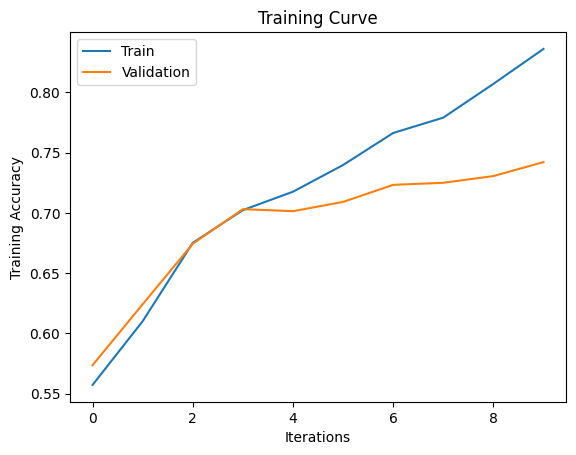

Final Training Accuracy: 0.8359274596601457
Final Validation Accuracy: 0.7420736932305055


In [103]:
model_cnn_4 = CNNClassifier() # 7000 training images
train(model_cnn_4, train_dataset, val_dataset, batch_size=512, lr=0.01, num_epochs=10)

In [106]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.pool(self.conv1(x))))
        x = self.cbam1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        
        x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5650435527631015 | Validation acc: 0.5844044558697515
Epoch 3: Train acc: 0.6472940168499215 | Validation acc: 0.6512425021422451
Epoch 4: Train acc: 0.6815650435527632 | Validation acc: 0.6812339331619537
Epoch 5: Train acc: 0.7018420676852778 | Validation acc: 0.694515852613539
Epoch 6: Train acc: 0.7318292160502642 | Validation acc: 0.7047986289631534
Epoch 7: Train acc: 0.7562473225760389 | Validation acc: 0.7082262210796915
Epoch 8: Train acc: 0.7922319006140226 | Validation acc: 0.720222793487575
Epoch 9: Train acc: 0.8403541339425961 | Validation acc: 0.7300771208226221
Epoch 10: Train acc: 0.8527773811223761 | Validation acc: 0.709083119108826
Total time elapsed: 236.27 s


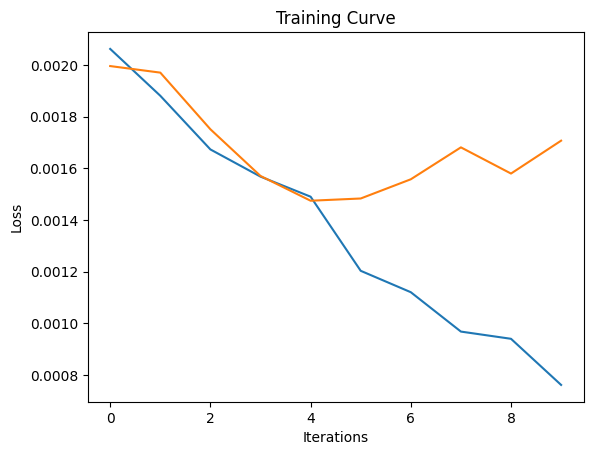

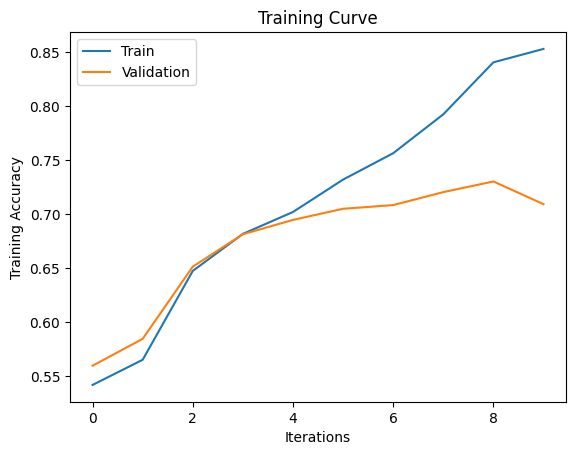

Final Training Accuracy: 0.8527773811223761
Final Validation Accuracy: 0.709083119108826


In [107]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=512, lr=0.01, num_epochs=10)

Epoch 1: Train acc: 0.5393402827359703 | Validation acc: 0.5539845758354756
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5591259640102828
Epoch 3: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 4: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 5: Train acc: 0.542338997572469 | Validation acc: 0.5595544130248501
Epoch 6: Train acc: 0.5429101813508497 | Validation acc: 0.5595544130248501
Epoch 7: Train acc: 0.5467656718549193 | Validation acc: 0.5634104541559555
Epoch 8: Train acc: 0.553905469084678 | Validation acc: 0.570694087403599
Epoch 9: Train acc: 0.5639011852063401 | Validation acc: 0.5826906598114824
Epoch 10: Train acc: 0.5761816364415251 | Validation acc: 0.5925449871465296
Total time elapsed: 243.34 s


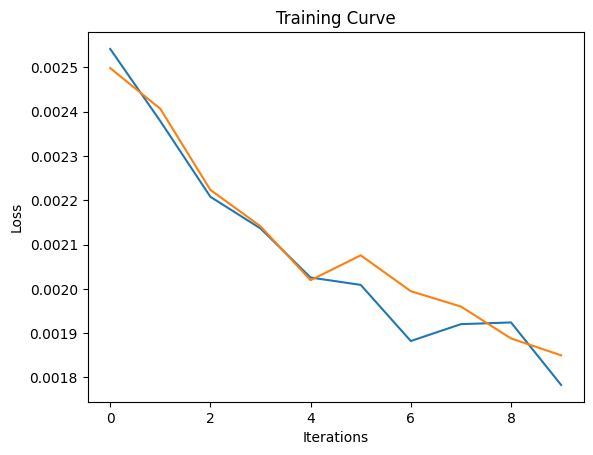

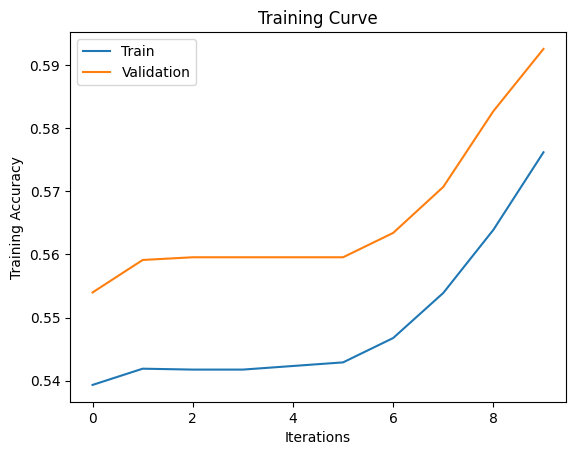

Final Training Accuracy: 0.5761816364415251
Final Validation Accuracy: 0.5925449871465296


In [108]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=512, lr=0.001, num_epochs=10)

In [109]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=30)

Epoch 1: Train acc: 0.5414822219048979 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.542338997572469 | Validation acc: 0.5629820051413882
Epoch 4: Train acc: 0.554762244752249 | Validation acc: 0.5715509854327335
Epoch 5: Train acc: 0.5796087391118092 | Validation acc: 0.6006855184233076
Epoch 6: Train acc: 0.6125946023132943 | Validation acc: 0.6233933161953727
Epoch 7: Train acc: 0.6368699128944738 | Validation acc: 0.6456726649528706
Epoch 8: Train acc: 0.6544338140796802 | Validation acc: 0.6675235646958012
Epoch 9: Train acc: 0.6668570612594602 | Validation acc: 0.6739502999143102
Epoch 10: Train acc: 0.6795659003284307 | Validation acc: 0.6846615252784919
Epoch 11: Train acc: 0.6895616164500928 | Validation acc: 0.6863753213367609
Epoch 12: Train acc: 0.7005569041839211 | Validation acc: 0.6958011996572407
Epoch 13: Train acc: 0.7114093959731543 | Validation acc: 0.6970865467009426
Epoch 14: 

KeyboardInterrupt: 

Epoch 1: Train acc: 0.5374839354562331 | Validation acc: 0.5535561268209083
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5578406169665809
Epoch 3: Train acc: 0.5421962016278737 | Validation acc: 0.5591259640102828
Epoch 4: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 5: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 6: Train acc: 0.5420534056832786 | Validation acc: 0.5595544130248501
Epoch 7: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 8: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 9: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 10: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 11: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 12: Train acc: 0.5420534056832786 | Validation acc: 0.5595544130248501
Epoch 13: Train acc: 0.5420534056832786 | Validation acc: 0.5599828620394173
Epoch 14

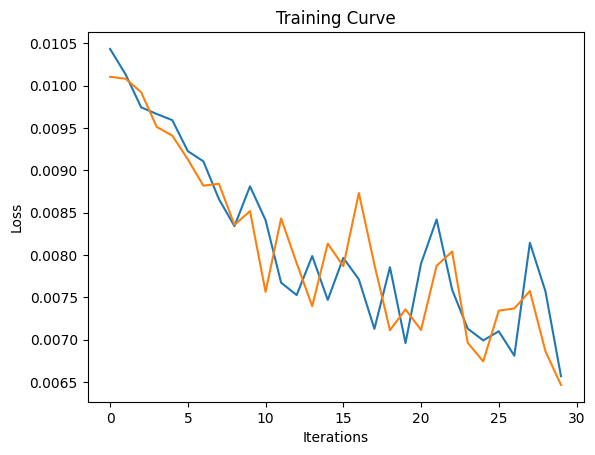

Final Training Accuracy: 0.6251606454376696
Final Validation Accuracy: 0.6379605826906598


In [110]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=30)

In [111]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=128, lr=0.01, num_epochs=30)

Epoch 1: Train acc: 0.665857489647294 | Validation acc: 0.6602399314481576
Epoch 2: Train acc: 0.7178352134799372 | Validation acc: 0.699228791773779
Epoch 3: Train acc: 0.7652434670855348 | Validation acc: 0.7150814053127678
Epoch 4: Train acc: 0.7889475938883336 | Validation acc: 0.7077977720651243
Epoch 5: Train acc: 0.8259317435384835 | Validation acc: 0.712082262210797
Epoch 6: Train acc: 0.8643438526345851 | Validation acc: 0.7116538131962297


KeyboardInterrupt: 

In [112]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=128, lr=0.0005, num_epochs=30)

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5489076110238469 | Validation acc: 0.5689802913453299
Epoch 4: Train acc: 0.5864629444523776 | Validation acc: 0.6023993144815767
Epoch 5: Train acc: 0.6290161359417392 | Validation acc: 0.6345329905741217
Epoch 6: Train acc: 0.6498643438526346 | Validation acc: 0.6563838903170522
Epoch 7: Train acc: 0.671569327431101 | Validation acc: 0.6645244215938303
Epoch 8: Train acc: 0.6777095530486934 | Validation acc: 0.6773778920308483
Epoch 9: Train acc: 0.6907039840068542 | Validation acc: 0.6838046272493573
Epoch 10: Train acc: 0.6964158217906612 | Validation acc: 0.6893744644387317
Epoch 11: Train acc: 0.7079822933028702 | Validation acc: 0.6953727506426736
Epoch 12: Train acc: 0.7166928459231758 | Validation acc: 0.6983718937446444
Epoch 13: Train acc: 0.7224046837069827 | Validation acc: 0.7030848329048843
Epoch 14:

KeyboardInterrupt: 

In [117]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(576, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        
        x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

In [118]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=128, lr=0.0005, num_epochs=30)

Epoch 1: Train acc: 0.5420534056832786 | Validation acc: 0.5599828620394173
Epoch 2: Train acc: 0.5894616592888762 | Validation acc: 0.6079691516709511
Epoch 3: Train acc: 0.6380122804512351 | Validation acc: 0.6478149100257069
Epoch 4: Train acc: 0.6678566328716264 | Validation acc: 0.6700942587832048
Epoch 5: Train acc: 0.680708267885192 | Validation acc: 0.6855184233076264
Epoch 6: Train acc: 0.6881336570041411 | Validation acc: 0.6868037703513282
Epoch 7: Train acc: 0.7025560474082536 | Validation acc: 0.700942587832048
Epoch 8: Train acc: 0.7149792945880337 | Validation acc: 0.707369323050557
Epoch 9: Train acc: 0.7301156647151221 | Validation acc: 0.7095115681233933
Epoch 10: Train acc: 0.7431100956732829 | Validation acc: 0.7159383033419023
Epoch 11: Train acc: 0.7593888333571327 | Validation acc: 0.7296486718080548
Epoch 12: Train acc: 0.7818077966585749 | Validation acc: 0.726649528706084
Epoch 13: Train acc: 0.7938026560045695 | Validation acc: 0.7287917737789203
Epoch 14: Tr

KeyboardInterrupt: 

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5446237326859917 | Validation acc: 0.5612682090831191
Epoch 3: Train acc: 0.5813222904469513 | Validation acc: 0.5895458440445587
Epoch 4: Train acc: 0.6255890332714551 | Validation acc: 0.6353898886032562
Epoch 5: Train acc: 0.6587176924175353 | Validation acc: 0.6606683804627249
Epoch 6: Train acc: 0.6705697558189347 | Validation acc: 0.6748071979434447
Epoch 7: Train acc: 0.680708267885192 | Validation acc: 0.6756640959725793
Epoch 8: Train acc: 0.6909895758960446 | Validation acc: 0.6949443016281063
Epoch 9: Train acc: 0.7029844352420391 | Validation acc: 0.6915167095115681
Epoch 10: Train acc: 0.7122661716407254 | Validation acc: 0.68808911739503
Total time elapsed: 349.28 s


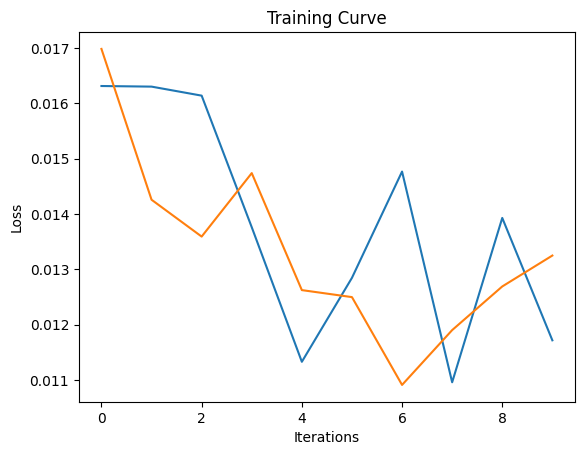

Final Training Accuracy: 0.7122661716407254
Final Validation Accuracy: 0.68808911739503


In [119]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=64, lr=0.0002, num_epochs=10)

Epoch 1: Train acc: 0.5419106097386834 | Validation acc: 0.5599828620394173
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5454805083535628 | Validation acc: 0.5646958011996572
Epoch 4: Train acc: 0.5623304298157933 | Validation acc: 0.5822622107969152
Epoch 5: Train acc: 0.5857489647294016 | Validation acc: 0.6032562125107113
Epoch 6: Train acc: 0.6051692131943452 | Validation acc: 0.6216795201371037
Epoch 7: Train acc: 0.6235898900471226 | Validation acc: 0.6388174807197944
Epoch 8: Train acc: 0.6415821790661145 | Validation acc: 0.6473864610111397
Epoch 9: Train acc: 0.6525774667999429 | Validation acc: 0.6576692373607541
Epoch 10: Train acc: 0.6600028559188919 | Validation acc: 0.6670951156812339
Total time elapsed: 355.62 s


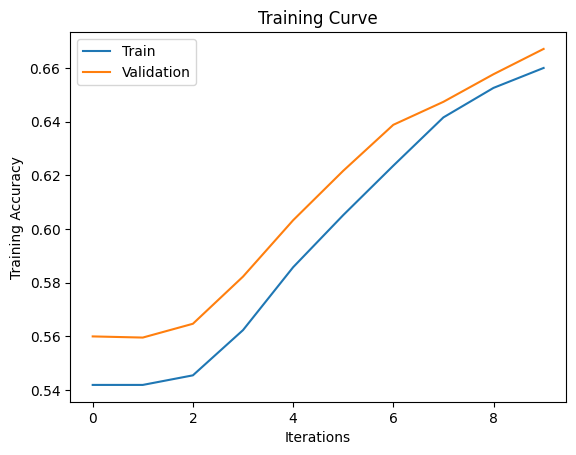

Final Training Accuracy: 0.6600028559188919
Final Validation Accuracy: 0.6670951156812339


In [120]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

In [121]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=30)

Epoch 1: Train acc: 0.5419106097386834 | Validation acc: 0.5599828620394173
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5454805083535628 | Validation acc: 0.5646958011996572
Epoch 4: Train acc: 0.5623304298157933 | Validation acc: 0.5822622107969152
Epoch 5: Train acc: 0.5857489647294016 | Validation acc: 0.6032562125107113
Epoch 6: Train acc: 0.6051692131943452 | Validation acc: 0.6216795201371037
Epoch 7: Train acc: 0.6235898900471226 | Validation acc: 0.6388174807197944
Epoch 8: Train acc: 0.6415821790661145 | Validation acc: 0.6473864610111397
Epoch 9: Train acc: 0.6525774667999429 | Validation acc: 0.6576692373607541
Epoch 10: Train acc: 0.6600028559188919 | Validation acc: 0.6670951156812339
Epoch 11: Train acc: 0.6709981436527203 | Validation acc: 0.6726649528706083
Epoch 12: Train acc: 0.6795659003284307 | Validation acc: 0.6726649528706083
Epoch 13: Train acc: 0.6832785948879052 | Validation acc: 0.6799485861182519
Epoch 14

KeyboardInterrupt: 

model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=512, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5537626731400829 | Validation acc: 0.5758354755784062
Epoch 4: Train acc: 0.6117378266457233 | Validation acc: 0.6251071122536418
Epoch 5: Train acc: 0.6474368127945166 | Validation acc: 0.6589545844044559
Epoch 6: Train acc: 0.6695701842067685 | Validation acc: 0.6718080548414739
Epoch 7: Train acc: 0.6824218192203342 | Validation acc: 0.6803770351328192
Epoch 8: Train acc: 0.6972725974582322 | Validation acc: 0.6919451585261354
Epoch 9: Train acc: 0.7044123946879909 | Validation acc: 0.6970865467009426
Epoch 10: Train acc: 0.7174068256461517 | Validation acc: 0.6970865467009426
Epoch 11: Train acc: 0.7282593174353849 | Validation acc: 0.7065124250214224
Epoch 12: Train acc: 0.7369698700556904 | Validation acc: 0.7077977720651243
Epoch 13: Train acc: 0.7503926888476368 | Validation acc: 0.7116538131962297
Epoch 14

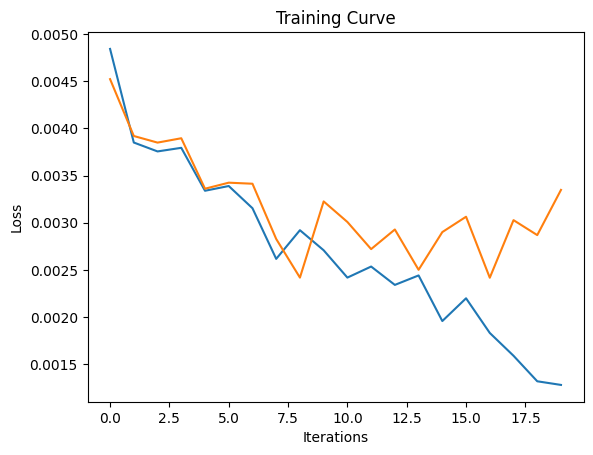

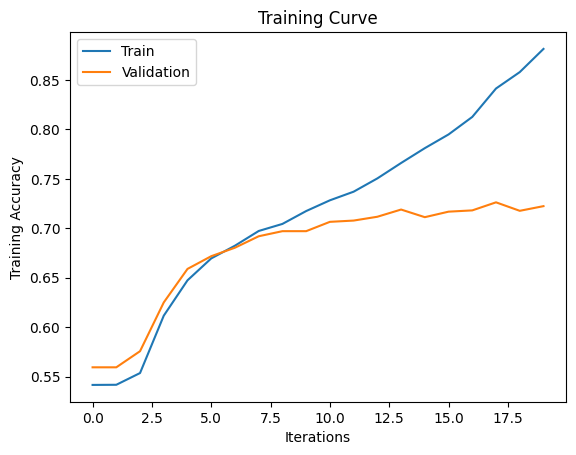

Final Training Accuracy: 0.8811937740968157
Final Validation Accuracy: 0.7223650385604113


In [123]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=20)

In [124]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=20)

Epoch 1: Train acc: 0.6741396544338141 | Validation acc: 0.6653813196229649
Epoch 2: Train acc: 0.7136941310866771 | Validation acc: 0.7060839760068551
Epoch 3: Train acc: 0.7512494645152078 | Validation acc: 0.7077977720651243
Epoch 4: Train acc: 0.7828073682707412 | Validation acc: 0.7275064267352185
Epoch 5: Train acc: 0.795944595173497 | Validation acc: 0.7369323050556984
Epoch 6: Train acc: 0.8250749678709125 | Validation acc: 0.7240788346186804
Epoch 7: Train acc: 0.8409253177209767 | Validation acc: 0.7275064267352185


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5491932029130373 | Validation acc: 0.5655526992287918
Epoch 4: Train acc: 0.5961730686848493 | Validation acc: 0.6165381319622965
Epoch 5: Train acc: 0.6385834642296159 | Validation acc: 0.6542416452442159
Epoch 6: Train acc: 0.6578609167499643 | Validation acc: 0.6662382176520995
Epoch 7: Train acc: 0.6688562044837927 | Validation acc: 0.668808911739503
Epoch 8: Train acc: 0.6872768813365701 | Validation acc: 0.6829477292202228
Epoch 9: Train acc: 0.6951306582893045 | Validation acc: 0.6855184233076264
Epoch 10: Train acc: 0.7042695987433957 | Validation acc: 0.6940874035989717
Epoch 11: Train acc: 0.7129801513637013 | Validation acc: 0.6859468723221936
Epoch 12: Train acc: 0.721833499928602 | Validation acc: 0.6949443016281063
Epoch 13: Train acc: 0.7328287876624304 | Validation acc: 0.7017994858611826
Epoch 14: 

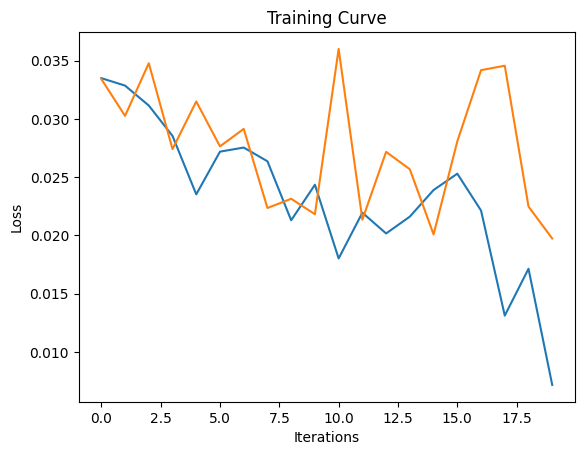

Final Training Accuracy: 0.8384977866628588
Final Validation Accuracy: 0.7215081405312768


In [125]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=32, lr=0.0001, num_epochs=20)

In [128]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

In [129]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.18492074825074967 | Validation acc: 0.16709511568123395
Epoch 2: Train acc: 0.2316150221333714 | Validation acc: 0.23864610111396745
Epoch 3: Train acc: 0.2808796230187063 | Validation acc: 0.29605826906598115
Epoch 4: Train acc: 0.3577038412109096 | Validation acc: 0.356898029134533
Epoch 5: Train acc: 0.40111380836784233 | Validation acc: 0.4104541559554413
Epoch 6: Train acc: 0.4432386120234185 | Validation acc: 0.4502999143101971
Epoch 7: Train acc: 0.4829358846208768 | Validation acc: 0.47986289631533846
Epoch 8: Train acc: 0.502927316864201 | Validation acc: 0.4987146529562982
Epoch 9: Train acc: 0.5303441382264744 | Validation acc: 0.5299914310197087
Epoch 10: Train acc: 0.5343424246751393 | Validation acc: 0.5501285347043702
Epoch 11: Train acc: 0.5530486934171069 | Validation acc: 0.5548414738646101
Epoch 12: Train acc: 0.5567613879765815 | Validation acc: 0.5616966580976864
Epoch 13: Train acc: 0.5634727973725546 | Validation acc: 0.5715509854327335
Epoc

Final Training Accuracy: 0.5776095958874768
Final Validation Accuracy: 0.5861182519280206


Epoch 1: Train acc: 0.41253748393545625 | Validation acc: 0.390745501285347
Epoch 2: Train acc: 0.5504783664143938 | Validation acc: 0.5548414738646101
Epoch 3: Train acc: 0.5537626731400829 | Validation acc: 0.5629820051413882
Epoch 4: Train acc: 0.5616164500928174 | Validation acc: 0.577120822622108
Epoch 5: Train acc: 0.5743252891617878 | Validation acc: 0.5938303341902313
Epoch 6: Train acc: 0.5890332714550907 | Validation acc: 0.6131105398457584
Epoch 7: Train acc: 0.607453948307868 | Validation acc: 0.6148243359040274
Epoch 8: Train acc: 0.6185920319862915 | Validation acc: 0.6306769494430163
Epoch 9: Train acc: 0.6281593602741682 | Validation acc: 0.6311053984575835
Epoch 10: Train acc: 0.6314436669998572 | Validation acc: 0.6379605826906598
Epoch 11: Train acc: 0.6420105668999 | Validation acc: 0.6456726649528706
Epoch 12: Train acc: 0.6465800371269456 | Validation acc: 0.6542416452442159
Epoch 13: Train acc: 0.648579180351278 | Validation acc: 0.6491002570694088
Epoch 14: Trai

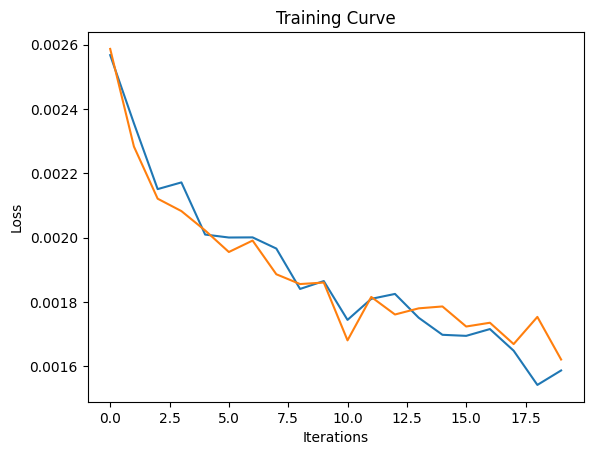

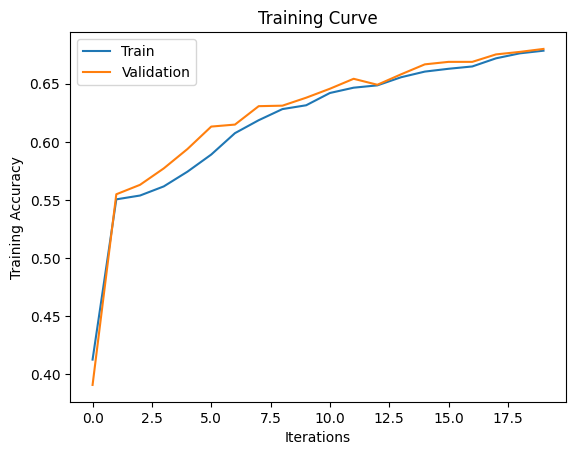

Final Training Accuracy: 0.6784235327716693
Final Validation Accuracy: 0.6799485861182519


In [130]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.001, num_epochs=20)

In [131]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.001, num_epochs=50)

Epoch 1: Train acc: 0.41253748393545625 | Validation acc: 0.390745501285347
Epoch 2: Train acc: 0.5504783664143938 | Validation acc: 0.5548414738646101
Epoch 3: Train acc: 0.5537626731400829 | Validation acc: 0.5629820051413882
Epoch 4: Train acc: 0.5616164500928174 | Validation acc: 0.577120822622108
Epoch 5: Train acc: 0.5743252891617878 | Validation acc: 0.5938303341902313
Epoch 6: Train acc: 0.5890332714550907 | Validation acc: 0.6131105398457584
Epoch 7: Train acc: 0.607453948307868 | Validation acc: 0.6148243359040274
Epoch 8: Train acc: 0.6185920319862915 | Validation acc: 0.6306769494430163
Epoch 9: Train acc: 0.6281593602741682 | Validation acc: 0.6311053984575835
Epoch 10: Train acc: 0.6314436669998572 | Validation acc: 0.6379605826906598
Epoch 11: Train acc: 0.6420105668999 | Validation acc: 0.6456726649528706
Epoch 12: Train acc: 0.6465800371269456 | Validation acc: 0.6542416452442159
Epoch 13: Train acc: 0.648579180351278 | Validation acc: 0.6491002570694088
Epoch 14: Trai

KeyboardInterrupt: 

In [132]:
def train(model, data, val_data=None, trial_num=0, batch_size=1, lr=0.01, num_epochs=10):
    torch.manual_seed(1000)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for imgs, labels in val_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            v_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy


        val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
        val_loss.append(float(v_loss)/batch_size)
        n += 1


        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [133]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

Epoch 1: Train acc: 0.5847493931172355 | Validation acc: 0.6036846615252784
Epoch 2: Train acc: 0.6594316721405112 | Validation acc: 0.6602399314481576
Epoch 3: Train acc: 0.6871340853919748 | Validation acc: 0.6756640959725793
Epoch 4: Train acc: 0.7005569041839211 | Validation acc: 0.699228791773779
Epoch 5: Train acc: 0.7241182350421248 | Validation acc: 0.7022279348757497
Epoch 6: Train acc: 0.7445380551192347 | Validation acc: 0.7107969151670951
Epoch 7: Train acc: 0.7543909752963016 | Validation acc: 0.7125107112253641
Epoch 8: Train acc: 0.7710981008139369 | Validation acc: 0.7189374464438731
Epoch 9: Train acc: 0.7932314722261887 | Validation acc: 0.7335047129391602
Epoch 10: Train acc: 0.798372126231615 | Validation acc: 0.7086546700942588
Total time elapsed: 231.60 s


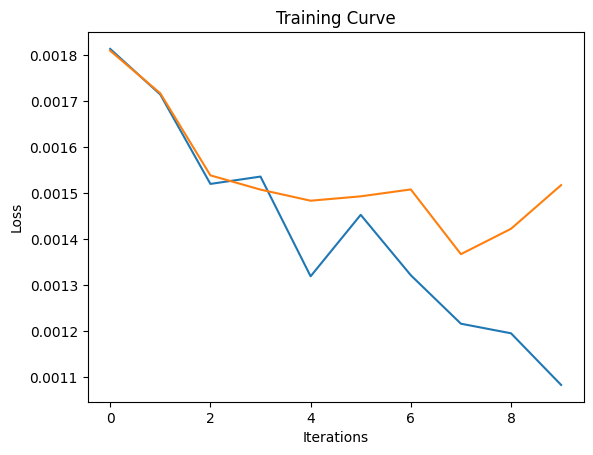

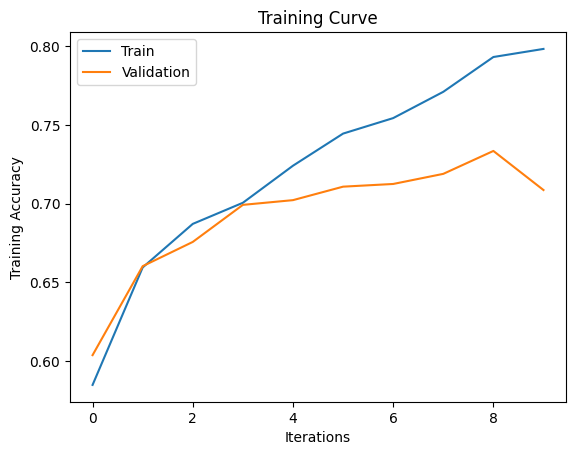

Final Training Accuracy: 0.798372126231615
Final Validation Accuracy: 0.7086546700942588


In [134]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.01, num_epochs=10)

Epoch 1: Train acc: 0.6787091246608596 | Validation acc: 0.6730934018851756
Epoch 2: Train acc: 0.7126945594745109 | Validation acc: 0.707369323050557
Epoch 3: Train acc: 0.7252606025988861 | Validation acc: 0.7116538131962297
Epoch 4: Train acc: 0.7225474796515778 | Validation acc: 0.696229648671808
Epoch 5: Train acc: 0.7376838497786663 | Validation acc: 0.7082262210796915
Epoch 6: Train acc: 0.7352563187205483 | Validation acc: 0.712082262210797
Epoch 7: Train acc: 0.7475367699557333 | Validation acc: 0.702656383890317
Epoch 8: Train acc: 0.7529630158503499 | Validation acc: 0.7167952013710368
Epoch 9: Train acc: 0.7709553048693417 | Validation acc: 0.7313624678663239
Epoch 10: Train acc: 0.7538197915179209 | Validation acc: 0.7107969151670951
Total time elapsed: 250.63 s


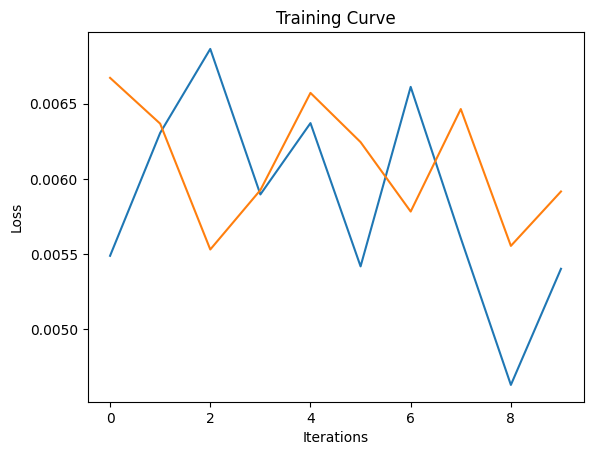

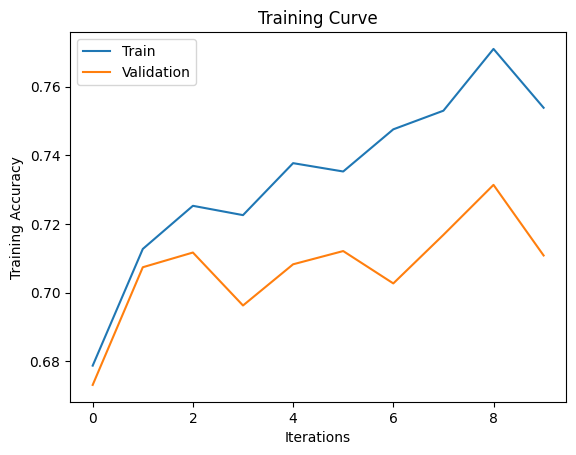

Final Training Accuracy: 0.7538197915179209
Final Validation Accuracy: 0.7107969151670951


In [135]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=128, lr=0.01, num_epochs=10)

In [136]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6909895758960446 | Validation acc: 0.6735218508997429
Epoch 2: Train acc: 0.7132657432528916 | Validation acc: 0.7000856898029134
Epoch 3: Train acc: 0.7435384835070684 | Validation acc: 0.7030848329048843
Epoch 4: Train acc: 0.7598172211909182 | Validation acc: 0.712082262210797
Epoch 5: Train acc: 0.785948879051835 | Validation acc: 0.718508997429306


KeyboardInterrupt: 

In [138]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=10)

KeyboardInterrupt: 

In [145]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

In [146]:
model_cnn_7 = CNNClassifier() # 7000 training images
train(model_cnn_7, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.6274453805511924 | Validation acc: 0.6409597257926307
Epoch 2: Train acc: 0.6684278166500072 | Validation acc: 0.662382176520994
Epoch 3: Train acc: 0.6958446380122805 | Validation acc: 0.6868037703513282
Epoch 4: Train acc: 0.7031272311866343 | Validation acc: 0.6988003427592117
Epoch 5: Train acc: 0.7261173782664573 | Validation acc: 0.7039417309340189
Epoch 6: Train acc: 0.7355419106097387 | Validation acc: 0.7107969151670951
Epoch 7: Train acc: 0.7536769955733257 | Validation acc: 0.718508997429306
Epoch 8: Train acc: 0.7678137940882479 | Validation acc: 0.7159383033419023


KeyboardInterrupt: 

In [147]:
model_cnn_7 = CNNClassifier() # 7000 training images
train(model_cnn_7, train_dataset, val_dataset, batch_size=32, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.6511495073539911 | Validation acc: 0.6482433590402742
Epoch 2: Train acc: 0.6744252463230044 | Validation acc: 0.6756640959725793
Epoch 3: Train acc: 0.7021276595744681 | Validation acc: 0.6975149957155099
Epoch 4: Train acc: 0.719405968870484 | Validation acc: 0.7103684661525278
Epoch 5: Train acc: 0.7401113808367842 | Validation acc: 0.7065124250214224
Epoch 6: Train acc: 0.7536769955733257 | Validation acc: 0.7176520994001714
Epoch 7: Train acc: 0.772811652149079 | Validation acc: 0.7270779777206512
Epoch 8: Train acc: 0.7978009424532343 | Validation acc: 0.7125107112253641
Epoch 9: Train acc: 0.8162216193060117 | Validation acc: 0.7257926306769494


KeyboardInterrupt: 

In [148]:
model_cnn_7 = CNNClassifier() # 7000 training images
train(model_cnn_7, train_dataset, val_dataset, batch_size=16, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.6478652006283021 | Validation acc: 0.6550985432733505
Epoch 2: Train acc: 0.6702841639297444 | Validation acc: 0.6743787489288775
Epoch 3: Train acc: 0.6952734542338997 | Validation acc: 0.68808911739503
Epoch 4: Train acc: 0.7112666000285592 | Validation acc: 0.7035132819194516
Epoch 5: Train acc: 0.7331143795516207 | Validation acc: 0.7005141388174807
Epoch 6: Train acc: 0.7526774239611596 | Validation acc: 0.7107969151670951
Epoch 7: Train acc: 0.7616735684706555 | Validation acc: 0.712082262210797
Epoch 8: Train acc: 0.7662430386977009 | Validation acc: 0.7150814053127678


KeyboardInterrupt: 

In [149]:
model_cnn_7 = CNNClassifier() # 7000 training images
train(model_cnn_7, train_dataset, val_dataset, batch_size=16, lr=0.00005, num_epochs=10)

Epoch 1: Train acc: 0.665857489647294 | Validation acc: 0.6580976863753213
Epoch 2: Train acc: 0.6932743110095674 | Validation acc: 0.6838046272493573
Epoch 3: Train acc: 0.7049835784663716 | Validation acc: 0.6975149957155099
Epoch 4: Train acc: 0.7172640297015564 | Validation acc: 0.7000856898029134
Epoch 5: Train acc: 0.7338283592745966 | Validation acc: 0.700942587832048
Epoch 6: Train acc: 0.7495359131800657 | Validation acc: 0.712082262210797
Epoch 7: Train acc: 0.7668142224760817 | Validation acc: 0.7082262210796915
Epoch 8: Train acc: 0.780237041268028 | Validation acc: 0.7082262210796915
Epoch 9: Train acc: 0.7946594316721405 | Validation acc: 0.7236503856041131
Epoch 10: Train acc: 0.8053691275167785 | Validation acc: 0.7167952013710368
Total time elapsed: 353.58 s


Final Training Accuracy: 0.8053691275167785
Final Validation Accuracy: 0.7167952013710368


In [150]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.582750249892903 | Validation acc: 0.583547557840617
Epoch 2: Train acc: 0.6183064400971012 | Validation acc: 0.6362467866323908
Epoch 3: Train acc: 0.6498643438526346 | Validation acc: 0.6568123393316195
Epoch 4: Train acc: 0.6631443666999857 | Validation acc: 0.6666666666666666
Epoch 5: Train acc: 0.6762815936027416 | Validation acc: 0.68337617823479
Epoch 6: Train acc: 0.6877052691703556 | Validation acc: 0.6919451585261354
Epoch 7: Train acc: 0.6958446380122805 | Validation acc: 0.6949443016281063
Epoch 8: Train acc: 0.7049835784663716 | Validation acc: 0.7013710368466153
Epoch 9: Train acc: 0.7115521919177495 | Validation acc: 0.6996572407883462
Epoch 10: Train acc: 0.718549193202913 | Validation acc: 0.7035132819194516
Epoch 11: Train acc: 0.7264029701556476 | Validation acc: 0.7095115681233933
Epoch 12: Train acc: 0.734970726831358 | Validation acc: 0.7103684661525278
Epoch 13: Train acc: 0.7405397686705698 | Validation acc: 0.7150814053127678
Epoch 14: Trai

Final Training Accuracy: 0.7972297586748537
Final Validation Accuracy: 0.7163667523564696


Epoch 1: Train acc: 0.5477652434670855 | Validation acc: 0.5377035132819195
Epoch 2: Train acc: 0.593459945737541 | Validation acc: 0.5814053127677806
Epoch 3: Train acc: 0.6133085820362701 | Validation acc: 0.6041131105398457
Epoch 4: Train acc: 0.6305868913322862 | Validation acc: 0.6336760925449871
Epoch 5: Train acc: 0.6454376695701842 | Validation acc: 0.6396743787489289
Epoch 6: Train acc: 0.6514350992431815 | Validation acc: 0.6520994001713796
Epoch 7: Train acc: 0.6644295302013423 | Validation acc: 0.6580976863753213
Epoch 8: Train acc: 0.669998572040554 | Validation acc: 0.6610968294772922
Epoch 9: Train acc: 0.6758532057689561 | Validation acc: 0.676949443016281
Epoch 10: Train acc: 0.6852777381122376 | Validation acc: 0.6885175664095973
Total time elapsed: 225.79 s


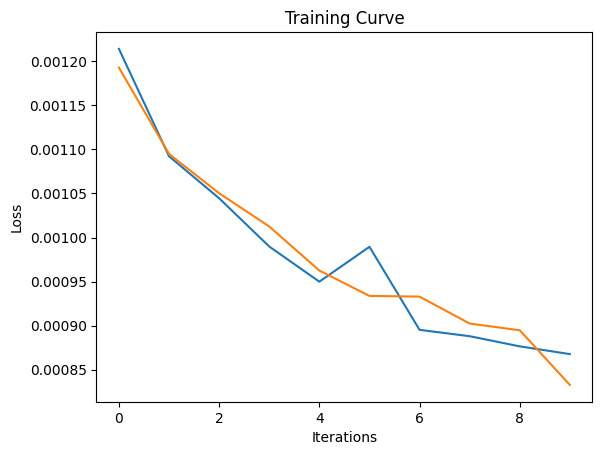

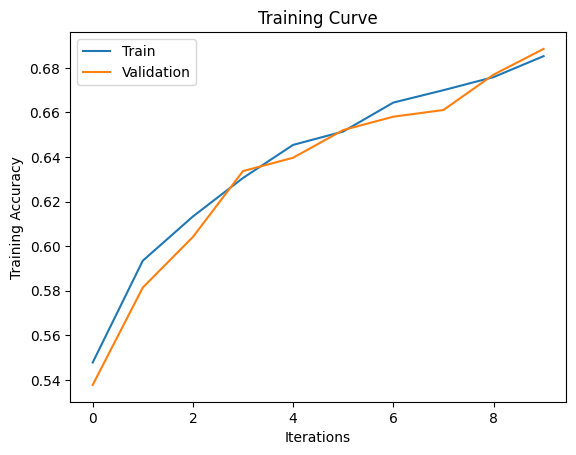

Final Training Accuracy: 0.6852777381122376
Final Validation Accuracy: 0.6885175664095973


In [151]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=1024, lr=0.0001, num_epochs=10)

In [152]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=1024, lr=0.0001, num_epochs=30)

Epoch 1: Train acc: 0.5123518492074826 | Validation acc: 0.5021422450728363
Epoch 2: Train acc: 0.6110238469227474 | Validation acc: 0.6203941730934018
Epoch 3: Train acc: 0.623875481936313 | Validation acc: 0.6272493573264781
Epoch 4: Train acc: 0.6330144223904041 | Validation acc: 0.6345329905741217
Epoch 5: Train acc: 0.6440097101242325 | Validation acc: 0.6495287060839761
Epoch 6: Train acc: 0.6571469370269885 | Validation acc: 0.6619537275064268
Epoch 7: Train acc: 0.6567185491932029 | Validation acc: 0.6692373607540703
Epoch 8: Train acc: 0.6672854490932457 | Validation acc: 0.6615252784918595
Epoch 9: Train acc: 0.6728544909324575 | Validation acc: 0.6765209940017138
Epoch 10: Train acc: 0.6785663287162644 | Validation acc: 0.681662382176521
Epoch 11: Train acc: 0.6809938597743824 | Validation acc: 0.6743787489288775
Epoch 12: Train acc: 0.6872768813365701 | Validation acc: 0.6790916880891174
Epoch 13: Train acc: 0.6934171069541625 | Validation acc: 0.68808911739503
Epoch 14: Tr

KeyboardInterrupt: 

In [159]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        # x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

In [160]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=1024, lr=0.0001, num_epochs=30)

Epoch 1: Train acc: 0.5660431243752677 | Validation acc: 0.5796915167095116
Epoch 2: Train acc: 0.5920319862915894 | Validation acc: 0.6075407026563839
Epoch 3: Train acc: 0.5993145794659431 | Validation acc: 0.6182519280205655
Epoch 4: Train acc: 0.6070255604740825 | Validation acc: 0.6272493573264781
Epoch 5: Train acc: 0.6241610738255033 | Validation acc: 0.6443873179091688
Epoch 6: Train acc: 0.6415821790661145 | Validation acc: 0.6435304198800342
Epoch 7: Train acc: 0.6517206911323719 | Validation acc: 0.6520994001713796
Epoch 8: Train acc: 0.6558617735256319 | Validation acc: 0.6683804627249358
Epoch 9: Train acc: 0.6640011423675568 | Validation acc: 0.6692373607540703
Epoch 10: Train acc: 0.6728544909324575 | Validation acc: 0.6739502999143102
Epoch 11: Train acc: 0.6778523489932886 | Validation acc: 0.6812339331619537
Epoch 12: Train acc: 0.6811366557189776 | Validation acc: 0.6773778920308483
Epoch 13: Train acc: 0.6889904326717121 | Validation acc: 0.6850899742930592
Epoch 14

KeyboardInterrupt: 

In [161]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=20)

Epoch 1: Train acc: 0.6802798800514065 | Validation acc: 0.6760925449871465
Epoch 2: Train acc: 0.7162644580893902 | Validation acc: 0.7095115681233933
Epoch 3: Train acc: 0.7385406254462373 | Validation acc: 0.7112253641816624
Epoch 4: Train acc: 0.7698129373125803 | Validation acc: 0.7245072836332477
Epoch 5: Train acc: 0.7908039411680708 | Validation acc: 0.7245072836332477


KeyboardInterrupt: 

In [162]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.644438097958018 | Validation acc: 0.6478149100257069
Epoch 2: Train acc: 0.6725688990432672 | Validation acc: 0.6739502999143102
Epoch 3: Train acc: 0.6918463515636156 | Validation acc: 0.6803770351328192
Epoch 4: Train acc: 0.7012708839068971 | Validation acc: 0.6928020565552699
Epoch 5: Train acc: 0.7109810081393688 | Validation acc: 0.696229648671808


KeyboardInterrupt: 

In [163]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=128, lr=0.00005, num_epochs=20)

Epoch 1: Train acc: 0.623875481936313 | Validation acc: 0.6225364181662382
Epoch 2: Train acc: 0.6585748964729402 | Validation acc: 0.6640959725792631
Epoch 3: Train acc: 0.6717121233756961 | Validation acc: 0.6743787489288775
Epoch 4: Train acc: 0.6894188205054976 | Validation acc: 0.6893744644387317
Epoch 5: Train acc: 0.6949878623447094 | Validation acc: 0.6893744644387317
Epoch 6: Train acc: 0.7095530486934171 | Validation acc: 0.7000856898029134
Epoch 7: Train acc: 0.7149792945880337 | Validation acc: 0.7043701799485861
Epoch 8: Train acc: 0.7281165214907896 | Validation acc: 0.7095115681233933
Epoch 9: Train acc: 0.7332571754962159 | Validation acc: 0.7107969151670951
Epoch 10: Train acc: 0.7405397686705698 | Validation acc: 0.709083119108826
Epoch 11: Train acc: 0.7452520348422105 | Validation acc: 0.718508997429306
Epoch 12: Train acc: 0.7553905469084679 | Validation acc: 0.7197943444730077
Epoch 13: Train acc: 0.7601028130801085 | Validation acc: 0.7176520994001714
Epoch 14: T

KeyboardInterrupt: 

In [164]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.00005, num_epochs=20)

Epoch 1: Train acc: 0.5900328430672569 | Validation acc: 0.6118251928020566
Epoch 2: Train acc: 0.6258746251606454 | Validation acc: 0.6418166238217652
Epoch 3: Train acc: 0.6585748964729402 | Validation acc: 0.6632390745501285
Epoch 4: Train acc: 0.6742824503784093 | Validation acc: 0.6790916880891174
Epoch 5: Train acc: 0.6877052691703556 | Validation acc: 0.68808911739503
Epoch 6: Train acc: 0.6935599028987577 | Validation acc: 0.6902313624678663
Epoch 7: Train acc: 0.7062687419677282 | Validation acc: 0.6988003427592117
Epoch 8: Train acc: 0.7179780094245324 | Validation acc: 0.7022279348757497
Epoch 9: Train acc: 0.7306868484935027 | Validation acc: 0.7060839760068551
Epoch 10: Train acc: 0.7351135227759532 | Validation acc: 0.7112253641816624
Epoch 11: Train acc: 0.7523918320719691 | Validation acc: 0.718508997429306
Epoch 12: Train acc: 0.7648150792517493 | Validation acc: 0.7223650385604113
Epoch 13: Train acc: 0.7820933885477652 | Validation acc: 0.7245072836332477
Epoch 14: T

KeyboardInterrupt: 

In [165]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=16, lr=0.00005, num_epochs=20)

Epoch 1: Train acc: 0.6661430815364844 | Validation acc: 0.6679520137103685
Epoch 2: Train acc: 0.6811366557189776 | Validation acc: 0.68337617823479
Epoch 3: Train acc: 0.693845494787948 | Validation acc: 0.6889460154241646
Epoch 4: Train acc: 0.7222618877623875 | Validation acc: 0.707369323050557
Epoch 5: Train acc: 0.7405397686705698 | Validation acc: 0.7039417309340189
Epoch 6: Train acc: 0.7665286305868914 | Validation acc: 0.7189374464438731
Epoch 7: Train acc: 0.7823789804369556 | Validation acc: 0.7167952013710368
Epoch 8: Train acc: 0.8035127802370413 | Validation acc: 0.7159383033419023
Epoch 9: Train acc: 0.8282164786520063 | Validation acc: 0.7257926306769494
Epoch 10: Train acc: 0.8456375838926175 | Validation acc: 0.7180805484147387
Epoch 11: Train acc: 0.8696273025846066 | Validation acc: 0.7180805484147387


KeyboardInterrupt: 

In [167]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=8, lr=0.00005, num_epochs=20)

Epoch 1: Train acc: 0.6401542196201628 | Validation acc: 0.6529562982005142
Epoch 2: Train acc: 0.675710409824361 | Validation acc: 0.6760925449871465
Epoch 3: Train acc: 0.6882764529487363 | Validation acc: 0.6838046272493573
Epoch 4: Train acc: 0.7044123946879909 | Validation acc: 0.6923736075407027
Epoch 5: Train acc: 0.7161216621447951 | Validation acc: 0.696229648671808


KeyboardInterrupt: 

In [169]:
def train(model, data, val_data=None, trial_num=0, batch_size=1, lr=0.01, num_epochs=10):
    torch.manual_seed(1000)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=1e-4)


    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for imgs, labels in val_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            v_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy


        val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
        val_loss.append(float(v_loss)/batch_size)
        n += 1


        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [170]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.00005, num_epochs=20)

Epoch 1: Train acc: 0.19206054548050835 | Validation acc: 0.18251928020565553
Epoch 2: Train acc: 0.21433671283735542 | Validation acc: 0.20179948586118251
Epoch 3: Train acc: 0.25289161787805226 | Validation acc: 0.23179091688089118
Epoch 4: Train acc: 0.2957304012566043 | Validation acc: 0.2866323907455013
Epoch 5: Train acc: 0.3311437955162073 | Validation acc: 0.337617823479006
Epoch 6: Train acc: 0.3651292303298586 | Validation acc: 0.3658954584404456
Epoch 7: Train acc: 0.40554048265029274 | Validation acc: 0.39931448157669236
Epoch 8: Train acc: 0.42067685277738115 | Validation acc: 0.4241645244215938
Epoch 9: Train acc: 0.45109238897615306 | Validation acc: 0.44601542416452444
Epoch 10: Train acc: 0.4687990861059546 | Validation acc: 0.461439588688946
Epoch 11: Train acc: 0.48050835356275884 | Validation acc: 0.4820051413881748
Epoch 12: Train acc: 0.49435956018849064 | Validation acc: 0.4888603256212511


KeyboardInterrupt: 

In [171]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.37112666000285593 | Validation acc: 0.3684661525278492
Epoch 2: Train acc: 0.4392403255747537 | Validation acc: 0.44430162810625534
Epoch 3: Train acc: 0.4910752534628017 | Validation acc: 0.493573264781491
Epoch 4: Train acc: 0.5129230329858632 | Validation acc: 0.5124250214224507
Epoch 5: Train acc: 0.522633157218335 | Validation acc: 0.5287060839760068
Epoch 6: Train acc: 0.5273454233899757 | Validation acc: 0.5377035132819195
Epoch 7: Train acc: 0.5322004855062116 | Validation acc: 0.5437017994858612
Epoch 8: Train acc: 0.5346280165643296 | Validation acc: 0.5415595544130248
Epoch 9: Train acc: 0.5374839354562331 | Validation acc: 0.5505569837189375
Epoch 10: Train acc: 0.5377695273454234 | Validation acc: 0.5479862896315338
Epoch 11: Train acc: 0.5400542624589462 | Validation acc: 0.5539845758354756
Epoch 12: Train acc: 0.5426245894616593 | Validation acc: 0.5604113110539846
Epoch 13: Train acc: 0.5430529772954448 | Validation acc: 0.5565552699228792


KeyboardInterrupt: 

In [172]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.01, num_epochs=20)

Epoch 1: Train acc: 0.5474796515778952 | Validation acc: 0.5681233933161953
Epoch 2: Train acc: 0.6095958874767956 | Validation acc: 0.6186803770351328
Epoch 3: Train acc: 0.6504355276310153 | Validation acc: 0.6576692373607541
Epoch 4: Train acc: 0.6711409395973155 | Validation acc: 0.6722365038560412
Epoch 5: Train acc: 0.6897044123946879 | Validation acc: 0.6932305055698372
Epoch 6: Train acc: 0.7005569041839211 | Validation acc: 0.702656383890317
Epoch 7: Train acc: 0.7091246608596316 | Validation acc: 0.7022279348757497
Epoch 8: Train acc: 0.7236898472083393 | Validation acc: 0.7142245072836333
Epoch 9: Train acc: 0.733399971440811 | Validation acc: 0.7065124250214224


KeyboardInterrupt: 

In [174]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6014565186348708 | Validation acc: 0.6199657240788347
Epoch 2: Train acc: 0.6602884478080823 | Validation acc: 0.6602399314481576
Epoch 3: Train acc: 0.6875624732257604 | Validation acc: 0.681662382176521
Epoch 4: Train acc: 0.7034128230758246 | Validation acc: 0.6953727506426736
Epoch 5: Train acc: 0.7228330715407683 | Validation acc: 0.6988003427592117
Epoch 6: Train acc: 0.7336855633300015 | Validation acc: 0.7099400171379606


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5450521205197773 | Validation acc: 0.5368466152527849
Epoch 2: Train acc: 0.5737541053834071 | Validation acc: 0.5856898029134533
Epoch 3: Train acc: 0.5764672283307154 | Validation acc: 0.5929734361610969
Epoch 4: Train acc: 0.5838926174496645 | Validation acc: 0.5998286203941731
Epoch 5: Train acc: 0.5904612309010424 | Validation acc: 0.6088260497000857
Epoch 6: Train acc: 0.5980294159645866 | Validation acc: 0.609254498714653
Epoch 7: Train acc: 0.6113094388119378 | Validation acc: 0.6268209083119108
Epoch 8: Train acc: 0.6187348279308867 | Validation acc: 0.6216795201371037
Epoch 9: Train acc: 0.6288733399971441 | Validation acc: 0.6418166238217652
Epoch 10: Train acc: 0.6315864629444524 | Validation acc: 0.6405312767780634
Total time elapsed: 124.87 s


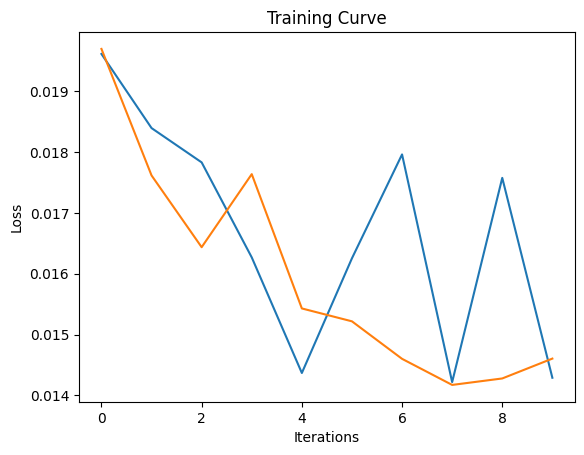

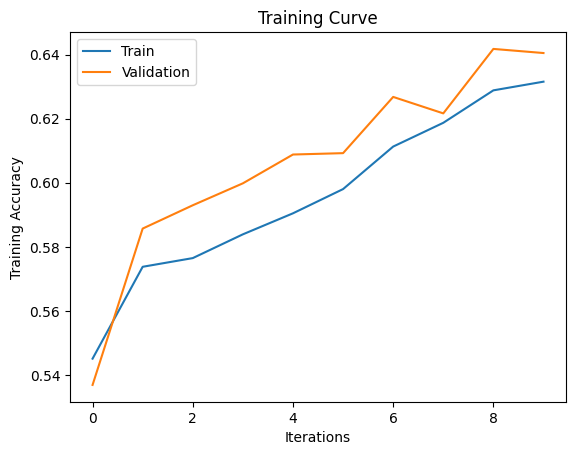

Final Training Accuracy: 0.6315864629444524
Final Validation Accuracy: 0.6405312767780634


In [175]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.1966300157075539 | Validation acc: 0.18337617823479005
Epoch 2: Train acc: 0.23618449236041697 | Validation acc: 0.23821765209940018
Epoch 3: Train acc: 0.2924460945309153 | Validation acc: 0.2814910025706941
Epoch 4: Train acc: 0.3442810224189633 | Validation acc: 0.3500428449014567
Epoch 5: Train acc: 0.3959731543624161 | Validation acc: 0.3963153384747215
Epoch 6: Train acc: 0.4416678566328716 | Validation acc: 0.4387317909168809
Epoch 7: Train acc: 0.481507925174925 | Validation acc: 0.47257926306769493
Epoch 8: Train acc: 0.5102099100385549 | Validation acc: 0.5077120822622108
Epoch 9: Train acc: 0.5257746679994288 | Validation acc: 0.5342759211653814
Epoch 10: Train acc: 0.5441953448522062 | Validation acc: 0.5501285347043702
Epoch 11: Train acc: 0.5559046123090104 | Validation acc: 0.5625535561268209
Epoch 12: Train acc: 0.5550478366414394 | Validation acc: 0.5651242502142245
Epoch 13: Train acc: 0.5714693702698843 | Validation acc: 0.5664095972579263
Epoch

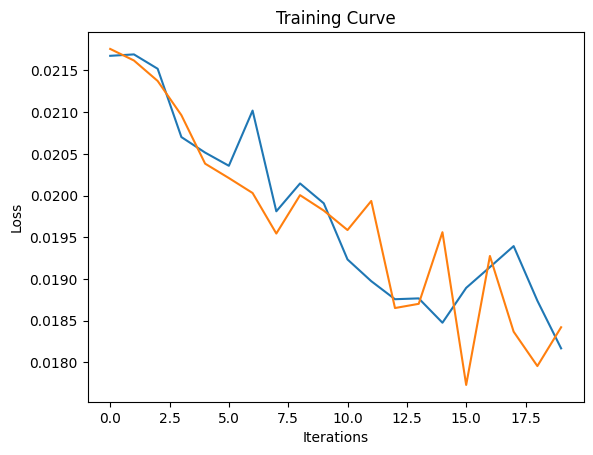

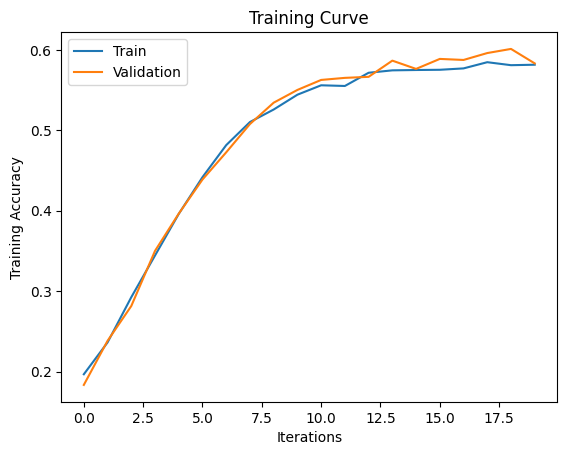

Final Training Accuracy: 0.5814650863915465
Final Validation Accuracy: 0.5831191088260497


In [176]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.00001, num_epochs=20)

Epoch 1: Train acc: 0.5436241610738255 | Validation acc: 0.5616966580976864
Epoch 2: Train acc: 0.544909324575182 | Validation acc: 0.5634104541559555
Epoch 3: Train acc: 0.5454805083535628 | Validation acc: 0.5612682090831191
Epoch 4: Train acc: 0.5459088961873483 | Validation acc: 0.5621251071122536
Epoch 5: Train acc: 0.5469084677995145 | Validation acc: 0.5638389031705227
Epoch 6: Train acc: 0.5490504069684421 | Validation acc: 0.5672664952870609
Epoch 7: Train acc: 0.5541910609738684 | Validation acc: 0.5702656383890317
Epoch 8: Train acc: 0.5603312865914608 | Validation acc: 0.5758354755784062
Epoch 9: Train acc: 0.5667571040982436 | Validation acc: 0.585261353898886
Epoch 10: Train acc: 0.5757532486077396 | Validation acc: 0.5929734361610969
Epoch 11: Train acc: 0.5811794945023562 | Validation acc: 0.6066838046272494
Epoch 12: Train acc: 0.5884620876767099 | Validation acc: 0.6032562125107113
Epoch 13: Train acc: 0.5960302727402542 | Validation acc: 0.617395029991431
Epoch 14: T

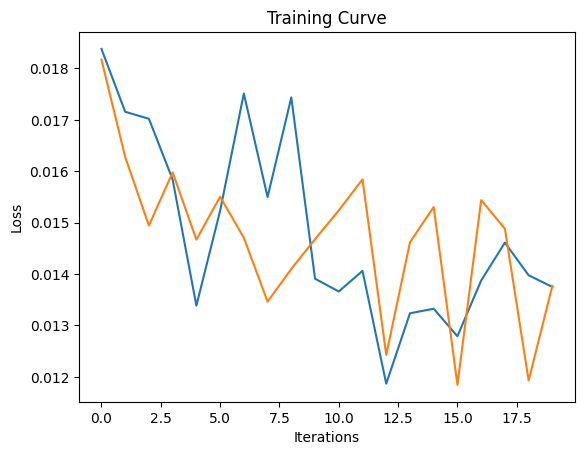

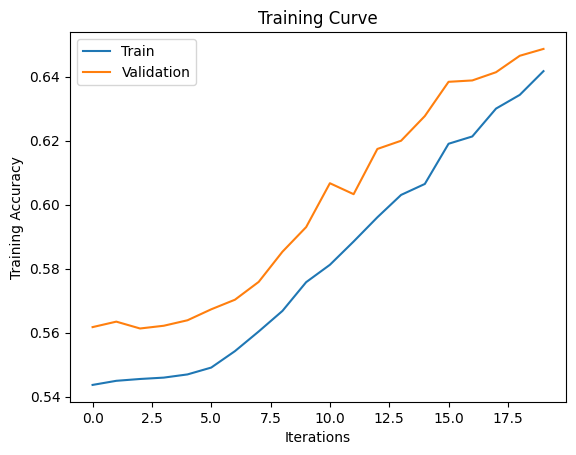

Final Training Accuracy: 0.6417249750107097
Final Validation Accuracy: 0.6486718080548415


In [177]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

In [178]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
      #  x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
       # x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        # x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

Epoch 1: Train acc: 0.6158789090389833 | Validation acc: 0.6233933161953727
Epoch 2: Train acc: 0.6408681993431387 | Validation acc: 0.6593830334190232
Epoch 3: Train acc: 0.6590032843067257 | Validation acc: 0.6602399314481576
Epoch 4: Train acc: 0.6672854490932457 | Validation acc: 0.6670951156812339
Epoch 5: Train acc: 0.6787091246608596 | Validation acc: 0.670522707797772
Epoch 6: Train acc: 0.6825646151649293 | Validation acc: 0.68808911739503
Epoch 7: Train acc: 0.6919891475082107 | Validation acc: 0.689802913453299
Epoch 8: Train acc: 0.6932743110095674 | Validation acc: 0.6829477292202228
Epoch 9: Train acc: 0.7014136798514922 | Validation acc: 0.6859468723221936
Epoch 10: Train acc: 0.7031272311866343 | Validation acc: 0.6919451585261354
Total time elapsed: 123.44 s


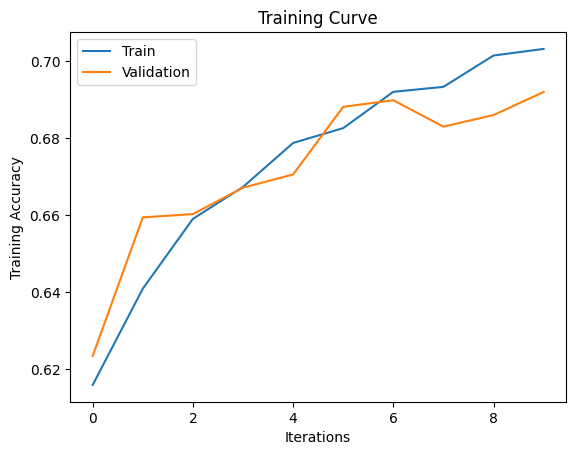

Final Training Accuracy: 0.7031272311866343
Final Validation Accuracy: 0.6919451585261354


In [179]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.6607168356418678 | Validation acc: 0.655955441302485
Epoch 2: Train acc: 0.6904183921176639 | Validation acc: 0.681662382176521
Epoch 3: Train acc: 0.708696273025846 | Validation acc: 0.6979434447300771
Epoch 4: Train acc: 0.7224046837069827 | Validation acc: 0.7116538131962297
Epoch 5: Train acc: 0.7335427673854062 | Validation acc: 0.6979434447300771
Epoch 6: Train acc: 0.7431100956732829 | Validation acc: 0.713796058269066
Epoch 7: Train acc: 0.7576752820219905 | Validation acc: 0.7112253641816624
Epoch 8: Train acc: 0.7683849778666286 | Validation acc: 0.7133676092544987
Epoch 9: Train acc: 0.7778095102099101 | Validation acc: 0.709083119108826
Epoch 10: Train acc: 0.781093816935599 | Validation acc: 0.7189374464438731
Total time elapsed: 130.93 s


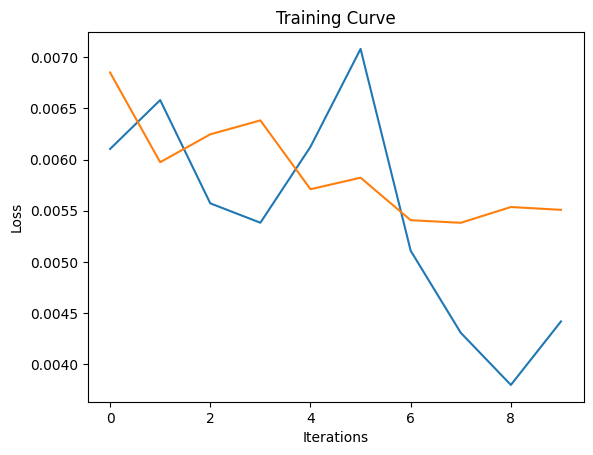

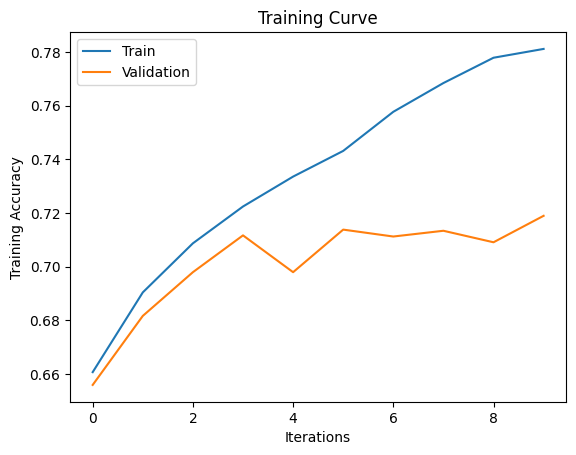

Final Training Accuracy: 0.781093816935599
Final Validation Accuracy: 0.7189374464438731


In [180]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

In [197]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
       
        
        x = F.relu(self.conv1(x))
        x = self.cbam1(x)


        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
       # x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        # x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

In [198]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6749964301013851 | Validation acc: 0.6679520137103685
Epoch 2: Train acc: 0.7016992717406826 | Validation acc: 0.6923736075407027
Epoch 3: Train acc: 0.7212623161502213 | Validation acc: 0.6949443016281063
Epoch 4: Train acc: 0.746537198343567 | Validation acc: 0.7180805484147387
Epoch 5: Train acc: 0.7639583035841782 | Validation acc: 0.709083119108826
Epoch 6: Train acc: 0.7666714265314865 | Validation acc: 0.7159383033419023


KeyboardInterrupt: 

In [209]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
       
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)


        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

Epoch 1: Train acc: 0.467513922604598 | Validation acc: 0.47643530419880037
Epoch 2: Train acc: 0.553905469084678 | Validation acc: 0.5629820051413882
Epoch 3: Train acc: 0.5828930458374982 | Validation acc: 0.5908311910882605
Epoch 4: Train acc: 0.5953162930172783 | Validation acc: 0.6002570694087404
Epoch 5: Train acc: 0.6003141510781094 | Validation acc: 0.6161096829477292
Epoch 6: Train acc: 0.6077395401970584 | Validation acc: 0.6251071122536418
Epoch 7: Train acc: 0.6144509495930316 | Validation acc: 0.6178234790059983
Epoch 8: Train acc: 0.623875481936313 | Validation acc: 0.6255355612682091
Epoch 9: Train acc: 0.6235898900471226 | Validation acc: 0.6341045415595544
Epoch 10: Train acc: 0.6277309724403827 | Validation acc: 0.6452442159383034
Total time elapsed: 193.08 s


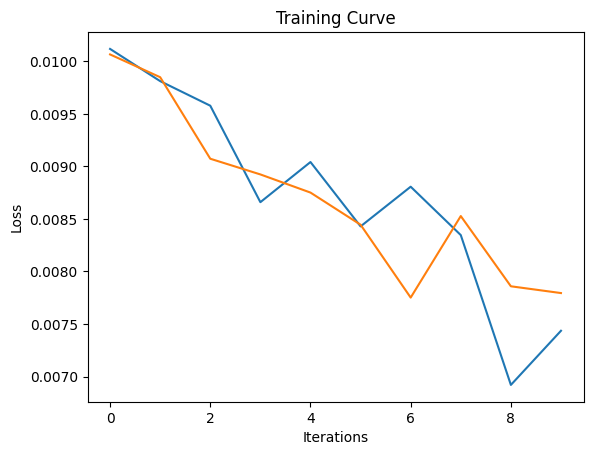

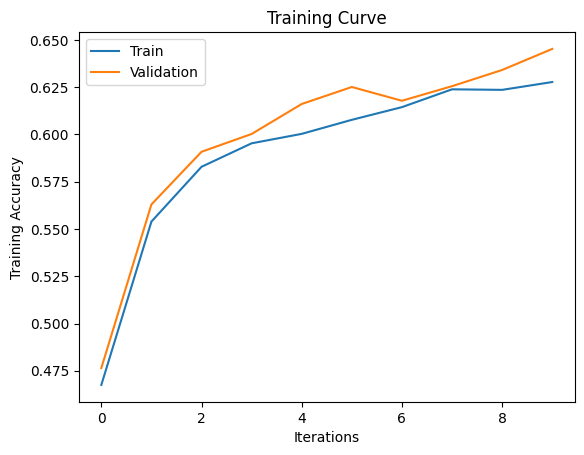

Final Training Accuracy: 0.6277309724403827
Final Validation Accuracy: 0.6452442159383034


In [210]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=10)

In [215]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch 1: Train acc: 0.5956018849064687 | Validation acc: 0.5874035989717223
Epoch 2: Train acc: 0.6441525060688277 | Validation acc: 0.6469580119965724
Epoch 3: Train acc: 0.646865629016136 | Validation acc: 0.6538131962296486
Epoch 4: Train acc: 0.6562901613594174 | Validation acc: 0.6538131962296486
Epoch 5: Train acc: 0.6647151220905326 | Validation acc: 0.6679520137103685
Epoch 6: Train acc: 0.671569327431101 | Validation acc: 0.6593830334190232
Epoch 7: Train acc: 0.6865629016135941 | Validation acc: 0.6713796058269066
Epoch 8: Train acc: 0.697129801513637 | Validation acc: 0.6760925449871465
Epoch 9: Train acc: 0.7089818649150365 | Validation acc: 0.6786632390745502
Epoch 10: Train acc: 0.7249750107096958 | Validation acc: 0.68808911739503
Total time elapsed: 224.63 s


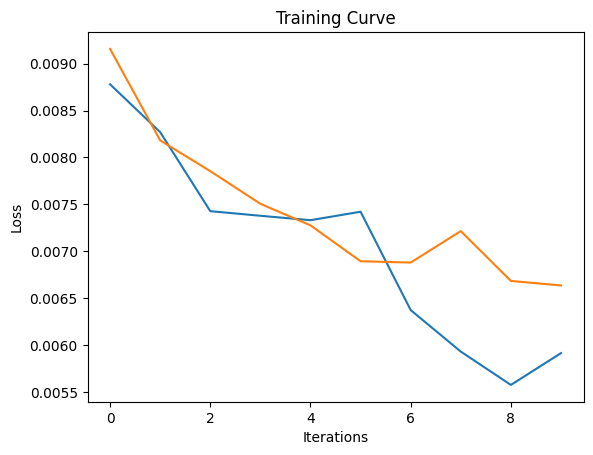

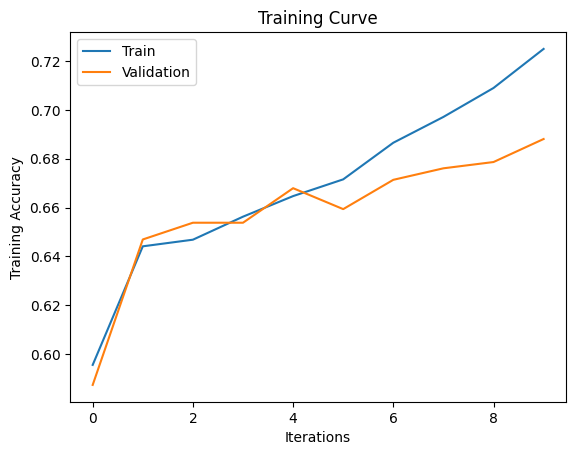

Final Training Accuracy: 0.7249750107096958
Final Validation Accuracy: 0.68808911739503


In [216]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.31772097672426103 | Validation acc: 0.30762639245929735
Epoch 2: Train acc: 0.3582750249892903 | Validation acc: 0.3577549271636675
Epoch 3: Train acc: 0.39425960302727403 | Validation acc: 0.3860325621251071
Epoch 4: Train acc: 0.40668285020705414 | Validation acc: 0.39588688946015427
Epoch 5: Train acc: 0.4328145080679709 | Validation acc: 0.42245072836332476
Epoch 6: Train acc: 0.44909324575182064 | Validation acc: 0.4301628106255356
Epoch 7: Train acc: 0.45880336998429244 | Validation acc: 0.44601542416452444
Epoch 8: Train acc: 0.46580037126945595 | Validation acc: 0.45844044558697516
Epoch 9: Train acc: 0.4746537198343567 | Validation acc: 0.46315338474721507
Epoch 10: Train acc: 0.4910752534628017 | Validation acc: 0.4845758354755784
Total time elapsed: 222.97 s


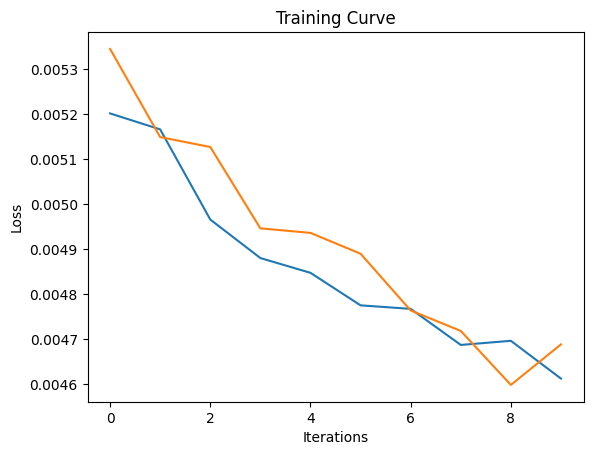

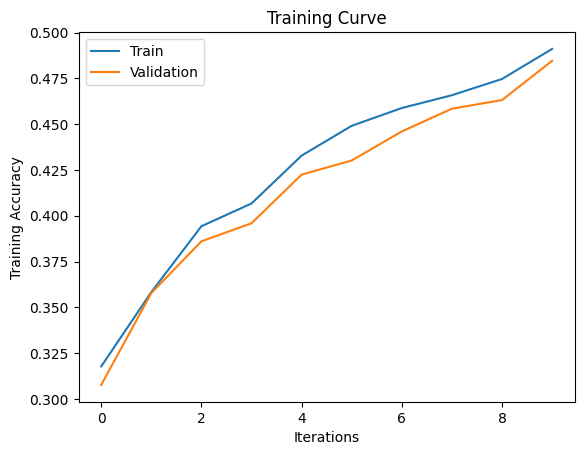

Final Training Accuracy: 0.4910752534628017
Final Validation Accuracy: 0.4845758354755784


In [217]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=256, lr=0.0001, num_epochs=10)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(3200, 1600)
        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.6054548050835357 | Validation acc: 0.6242502142245073
Epoch 3: Train acc: 0.6562901613594174 | Validation acc: 0.662382176520994
Epoch 4: Train acc: 0.682279023275739 | Validation acc: 0.6868037703513282
Epoch 5: Train acc: 0.6939882907325432 | Validation acc: 0.6902313624678663
Epoch 6: Train acc: 0.7062687419677282 | Validation acc: 0.7039417309340189
Epoch 7: Train acc: 0.7286877052691704 | Validation acc: 0.699228791773779
Epoch 8: Train acc: 0.7458232186205912 | Validation acc: 0.7133676092544987
Epoch 9: Train acc: 0.7449664429530202 | Validation acc: 0.713796058269066
Epoch 10: Train acc: 0.759674425246323 | Validation acc: 0.7279348757497858
Total time elapsed: 238.89 s


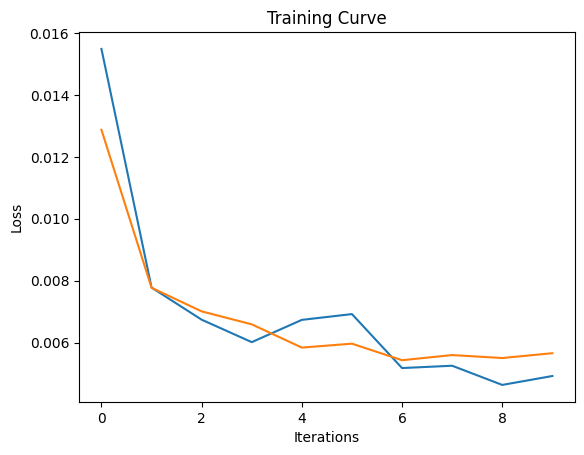

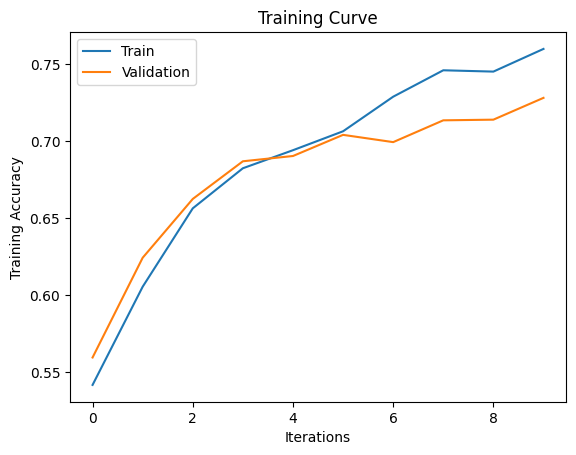

Final Training Accuracy: 0.759674425246323
Final Validation Accuracy: 0.7279348757497858


In [229]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

In [230]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.5416250178494931 | Validation acc: 0.5595544130248501
Epoch 2: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 3: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 4: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 5: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501
Epoch 6: Train acc: 0.5417678137940882 | Validation acc: 0.5595544130248501


KeyboardInterrupt: 

Epoch 1: Train acc: 0.6231615022133371 | Validation acc: 0.6315338474721508
Epoch 2: Train acc: 0.6882764529487363 | Validation acc: 0.6859468723221936
Epoch 3: Train acc: 0.7212623161502213 | Validation acc: 0.7099400171379606
Epoch 4: Train acc: 0.7296872768813366 | Validation acc: 0.6919451585261354
Epoch 5: Train acc: 0.7513922604598029 | Validation acc: 0.7283633247643531
Epoch 6: Train acc: 0.7623875481936313 | Validation acc: 0.7159383033419023
Epoch 7: Train acc: 0.7849493074396687 | Validation acc: 0.7223650385604113
Epoch 8: Train acc: 0.8057975153505641 | Validation acc: 0.7360754070265638
Epoch 9: Train acc: 0.8205054976438669 | Validation acc: 0.7270779777206512
Epoch 10: Train acc: 0.8316435813222904 | Validation acc: 0.7300771208226221
Total time elapsed: 330.36 s


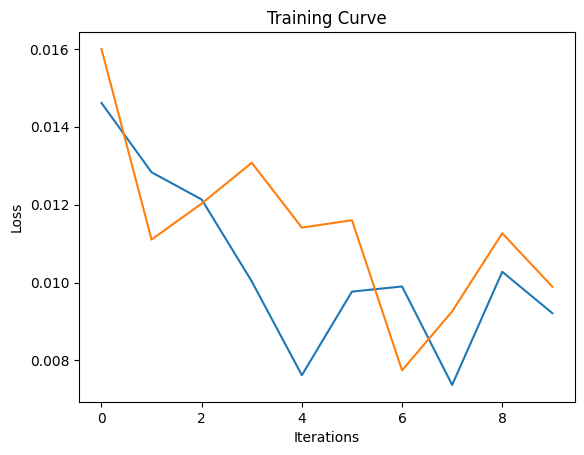

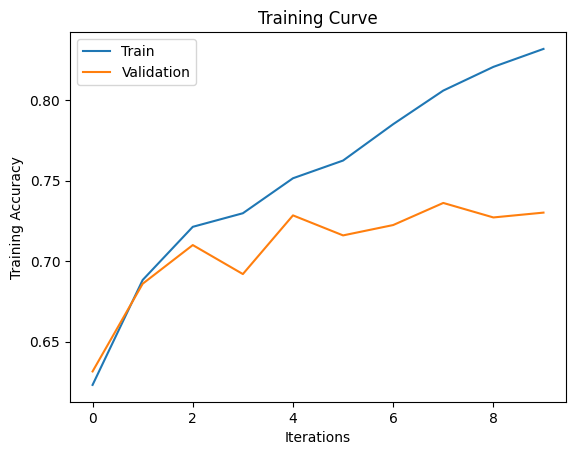

Final Training Accuracy: 0.8316435813222904
Final Validation Accuracy: 0.7300771208226221


In [231]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6674282450378409 | Validation acc: 0.6662382176520995
Epoch 2: Train acc: 0.7141225189204626 | Validation acc: 0.7047986289631534
Epoch 3: Train acc: 0.7275453377124089 | Validation acc: 0.7039417309340189
Epoch 4: Train acc: 0.7576752820219905 | Validation acc: 0.7279348757497858
Epoch 5: Train acc: 0.7872340425531915 | Validation acc: 0.7313624678663239
Epoch 6: Train acc: 0.8027988005140654 | Validation acc: 0.721936589545844
Epoch 7: Train acc: 0.8136512923032986 | Validation acc: 0.7317909168808912
Epoch 8: Train acc: 0.8153648436384406 | Validation acc: 0.7017994858611826
Epoch 9: Train acc: 0.8413537055547623 | Validation acc: 0.7180805484147387
Epoch 10: Train acc: 0.8663429958589176 | Validation acc: 0.7309340188517567
Total time elapsed: 414.66 s


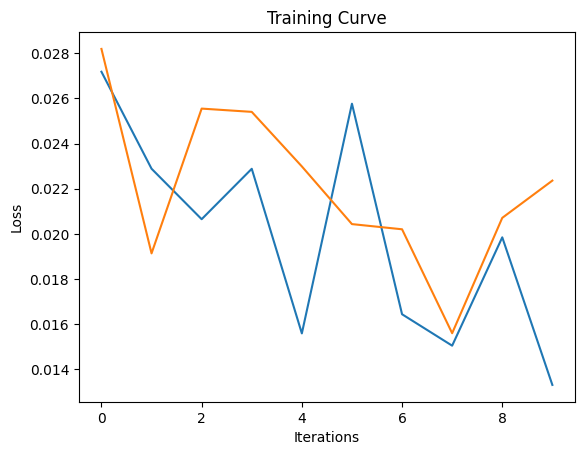

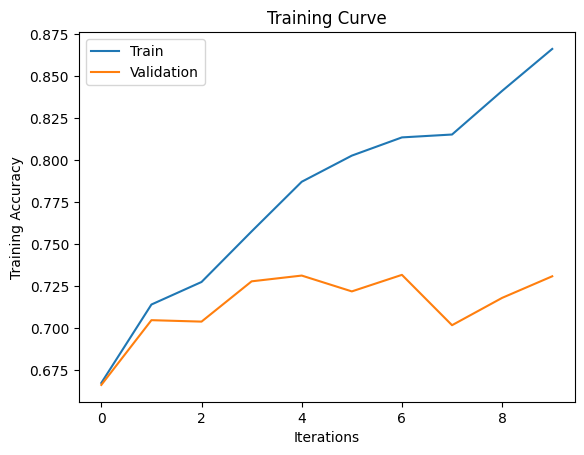

Final Training Accuracy: 0.8663429958589176
Final Validation Accuracy: 0.7309340188517567


In [232]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=10)

In [240]:
get_accuracy(model_cnn_9, test_dataset, 32)

0.7326478149100257

In [236]:
train_dataset

In [237]:
test_dataset

In [238]:
val_dataset

In [249]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 128)
        self.fc1 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
       # x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #x = self.cbam1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc1(x)
        return x

In [250]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6964158217906612 | Validation acc: 0.6778063410454156
Epoch 2: Train acc: 0.7258317863772669 | Validation acc: 0.7086546700942588
Epoch 3: Train acc: 0.7476795659003285 | Validation acc: 0.713796058269066
Epoch 4: Train acc: 0.7759531629301728 | Validation acc: 0.7287917737789203
Epoch 5: Train acc: 0.7858060831072398 | Validation acc: 0.7262210796915167
Epoch 6: Train acc: 0.8046551477938026 | Validation acc: 0.7240788346186804
Epoch 7: Train acc: 0.8112237612451806 | Validation acc: 0.7215081405312768


KeyboardInterrupt: 

In [251]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 128)
        self.fc1 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
       # x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #x = self.cbam1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc1(x)
        return x

In [252]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.7009852920177067 | Validation acc: 0.6765209940017138
Epoch 2: Train acc: 0.7292588890475511 | Validation acc: 0.7197943444730077
Epoch 3: Train acc: 0.7541053834071112 | Validation acc: 0.7159383033419023
Epoch 4: Train acc: 0.7738112237612452 | Validation acc: 0.7206512425021423


KeyboardInterrupt: 

Epoch 1: Train acc: 0.6110238469227474 | Validation acc: 0.6203941730934018
Epoch 2: Train acc: 0.6631443666999857 | Validation acc: 0.6632390745501285
Epoch 3: Train acc: 0.6799942881622162 | Validation acc: 0.6855184233076264
Epoch 4: Train acc: 0.69555904612309 | Validation acc: 0.6889460154241646
Epoch 5: Train acc: 0.7155504783664144 | Validation acc: 0.6988003427592117
Epoch 6: Train acc: 0.7255461944880766 | Validation acc: 0.7082262210796915
Epoch 7: Train acc: 0.739111809224618 | Validation acc: 0.7112253641816624
Epoch 8: Train acc: 0.747251178066543 | Validation acc: 0.718508997429306
Epoch 9: Train acc: 0.7565329144652292 | Validation acc: 0.7223650385604113
Epoch 10: Train acc: 0.7706697129801514 | Validation acc: 0.7210796915167095
Total time elapsed: 175.77 s


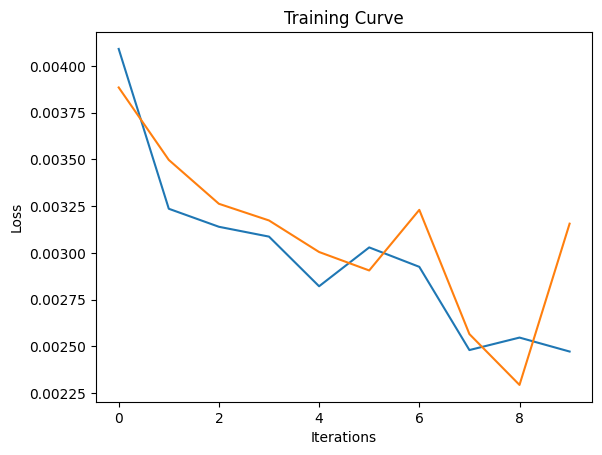

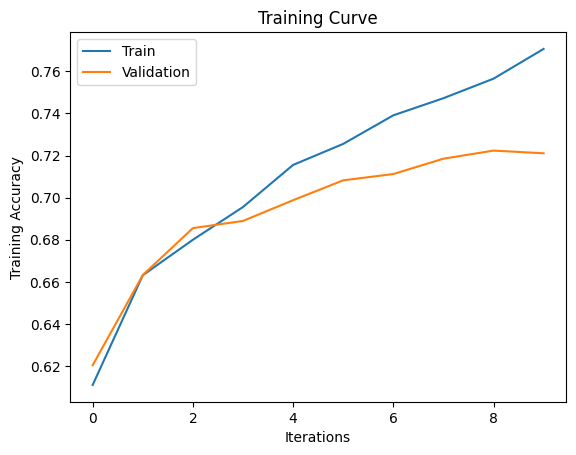

Final Training Accuracy: 0.7706697129801514
Final Validation Accuracy: 0.7210796915167095


In [253]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=10)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 128)
        self.fc1 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
       # x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc1(x)
        return x

Epoch 1: Train acc: 0.6254462373268599 | Validation acc: 0.6371036846615252
Epoch 2: Train acc: 0.6624303869770098 | Validation acc: 0.6675235646958012
Epoch 3: Train acc: 0.6781379408824789 | Validation acc: 0.6889460154241646
Epoch 4: Train acc: 0.6967014136798515 | Validation acc: 0.689802913453299
Epoch 5: Train acc: 0.7151220905326289 | Validation acc: 0.7039417309340189
Epoch 6: Train acc: 0.7302584606597172 | Validation acc: 0.7095115681233933
Epoch 7: Train acc: 0.7348279308867628 | Validation acc: 0.7082262210796915
Epoch 8: Train acc: 0.749821505069256 | Validation acc: 0.7283633247643531
Epoch 9: Train acc: 0.7603884049692988 | Validation acc: 0.718508997429306
Epoch 10: Train acc: 0.7696701413679852 | Validation acc: 0.720222793487575
Total time elapsed: 178.74 s


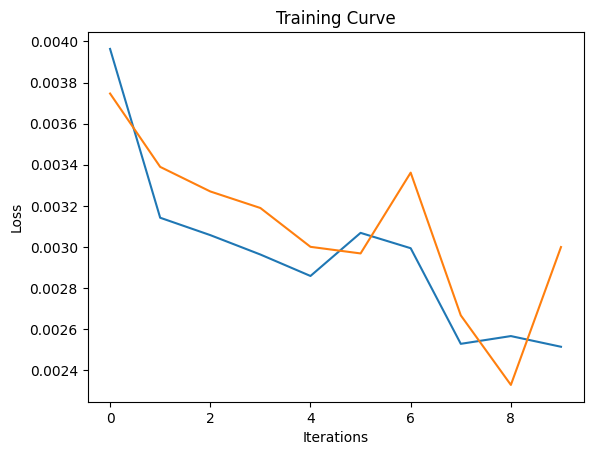

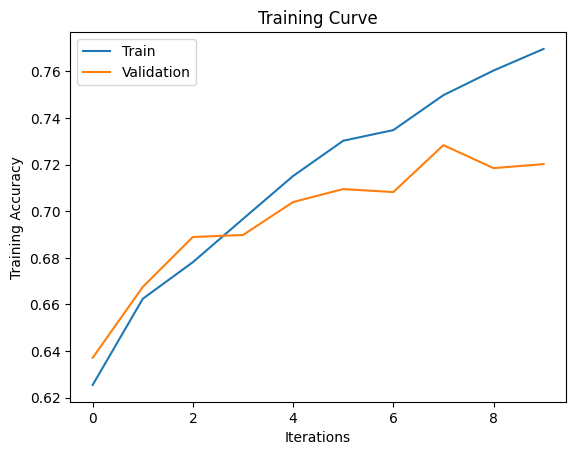

Final Training Accuracy: 0.7696701413679852
Final Validation Accuracy: 0.720222793487575


In [254]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=10)

In [256]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6881336570041411 | Validation acc: 0.6790916880891174
Epoch 2: Train acc: 0.72011994859346 | Validation acc: 0.702656383890317
Epoch 3: Train acc: 0.7459660145651863 | Validation acc: 0.7167952013710368
Epoch 4: Train acc: 0.7558189347422534 | Validation acc: 0.709083119108826
Epoch 5: Train acc: 0.7785234899328859 | Validation acc: 0.7270779777206512
Epoch 6: Train acc: 0.7972297586748537 | Validation acc: 0.720222793487575
Epoch 7: Train acc: 0.8095102099100385 | Validation acc: 0.7180805484147387


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5854633728402113 | Validation acc: 0.6058269065981148
Epoch 2: Train acc: 0.6341567899471655 | Validation acc: 0.6439588688946015
Epoch 3: Train acc: 0.6595744680851063 | Validation acc: 0.6606683804627249
Epoch 4: Train acc: 0.6687134085391975 | Validation acc: 0.662382176520994
Epoch 5: Train acc: 0.6787091246608596 | Validation acc: 0.6765209940017138
Epoch 6: Train acc: 0.6888476367271169 | Validation acc: 0.6958011996572407
Epoch 7: Train acc: 0.7019848636298729 | Validation acc: 0.6983718937446444
Epoch 8: Train acc: 0.7096958446380123 | Validation acc: 0.6910882604970009
Epoch 9: Train acc: 0.7152648864772241 | Validation acc: 0.7043701799485861
Epoch 10: Train acc: 0.7216907039840068 | Validation acc: 0.7052270779777207
Total time elapsed: 185.89 s


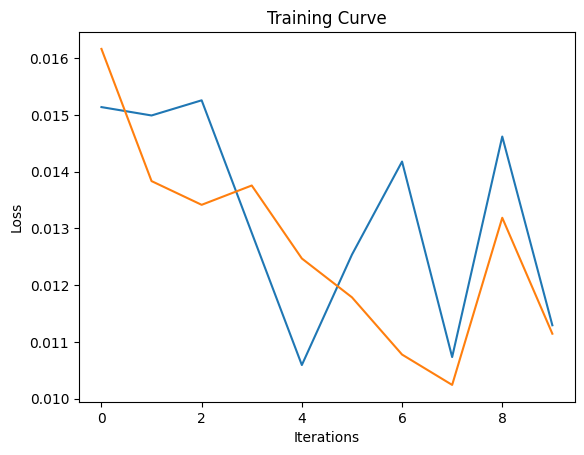

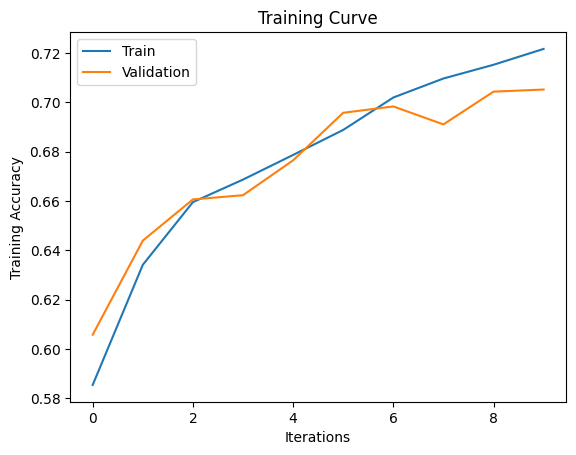

Final Training Accuracy: 0.7216907039840068
Final Validation Accuracy: 0.7052270779777207


In [257]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

Epoch 1: Train acc: 0.6645723261459374 | Validation acc: 0.6602399314481576
Epoch 2: Train acc: 0.7002713122947308 | Validation acc: 0.6970865467009426
Epoch 3: Train acc: 0.7245466228759103 | Validation acc: 0.7116538131962297
Epoch 4: Train acc: 0.7446808510638298 | Validation acc: 0.7150814053127678
Epoch 5: Train acc: 0.7635299157503926 | Validation acc: 0.7069408740359897
Epoch 6: Train acc: 0.7503926888476368 | Validation acc: 0.7069408740359897
Epoch 7: Train acc: 0.7839497358275025 | Validation acc: 0.7095115681233933
Epoch 8: Train acc: 0.7893759817221191 | Validation acc: 0.6953727506426736
Epoch 9: Train acc: 0.8180779665857489 | Validation acc: 0.7197943444730077
Epoch 10: Train acc: 0.8317863772668856 | Validation acc: 0.7249357326478149
Total time elapsed: 169.21 s


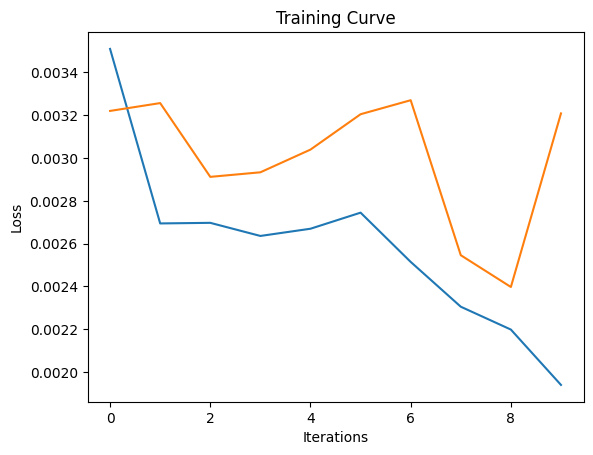

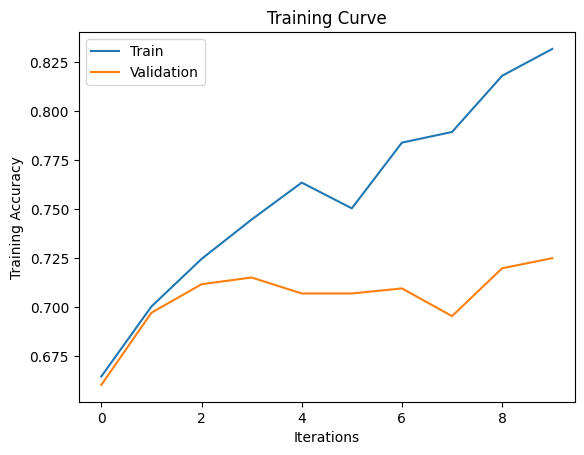

Final Training Accuracy: 0.8317863772668856
Final Validation Accuracy: 0.7249357326478149


In [259]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=256, lr=0.05, num_epochs=10)

In [260]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=256, lr=0.005, num_epochs=10)

Epoch 1: Train acc: 0.669998572040554 | Validation acc: 0.6606683804627249
Epoch 2: Train acc: 0.7011280879623019 | Validation acc: 0.700942587832048
Epoch 3: Train acc: 0.7228330715407683 | Validation acc: 0.7223650385604113
Epoch 4: Train acc: 0.7476795659003285 | Validation acc: 0.7167952013710368
Epoch 5: Train acc: 0.7626731400828216 | Validation acc: 0.726649528706084
Epoch 6: Train acc: 0.7820933885477652 | Validation acc: 0.721936589545844


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5793231472226189 | Validation acc: 0.6002570694087404
Epoch 2: Train acc: 0.6341567899471655 | Validation acc: 0.6456726649528706
Epoch 3: Train acc: 0.6502927316864201 | Validation acc: 0.6572407883461868
Epoch 4: Train acc: 0.6702841639297444 | Validation acc: 0.6726649528706083
Epoch 5: Train acc: 0.6785663287162644 | Validation acc: 0.6739502999143102
Epoch 6: Train acc: 0.6875624732257604 | Validation acc: 0.6808054841473865
Epoch 7: Train acc: 0.6957018420676853 | Validation acc: 0.6859468723221936
Epoch 8: Train acc: 0.7056975581893474 | Validation acc: 0.689802913453299
Epoch 9: Train acc: 0.7204055404826503 | Validation acc: 0.7000856898029134
Epoch 10: Train acc: 0.7266885620448379 | Validation acc: 0.7039417309340189
Total time elapsed: 237.96 s


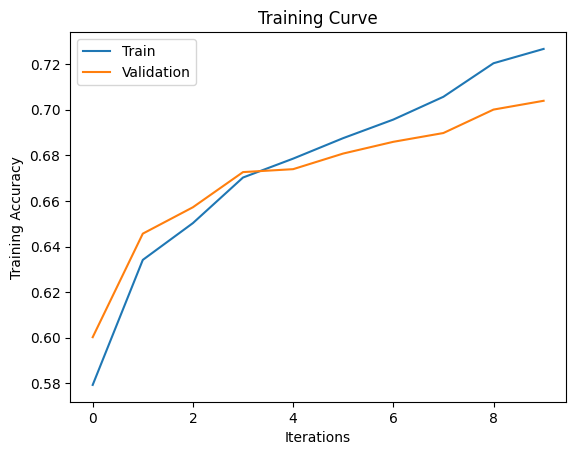

Final Training Accuracy: 0.7266885620448379
Final Validation Accuracy: 0.7039417309340189


In [261]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=256, lr=0.0005, num_epochs=10)

In [267]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 5, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, 16)
        self.fc1 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc1(x)
        return x

Epoch 1: Train acc: 0.5476224475224903 | Validation acc: 0.5638389031705227
Epoch 2: Train acc: 0.5647579608739112 | Validation acc: 0.5848329048843187
Epoch 3: Train acc: 0.6003141510781094 | Validation acc: 0.6186803770351328
Epoch 4: Train acc: 0.6285877481079537 | Validation acc: 0.6473864610111397
Epoch 5: Train acc: 0.6564329573040125 | Validation acc: 0.6666666666666666
Epoch 6: Train acc: 0.6804226759960017 | Validation acc: 0.6799485861182519
Epoch 7: Train acc: 0.6879908610595459 | Validation acc: 0.6863753213367609
Epoch 8: Train acc: 0.7039840068542054 | Validation acc: 0.6996572407883462
Epoch 9: Train acc: 0.7135513351420819 | Validation acc: 0.6979434447300771
Epoch 10: Train acc: 0.7245466228759103 | Validation acc: 0.6988003427592117
Total time elapsed: 236.83 s


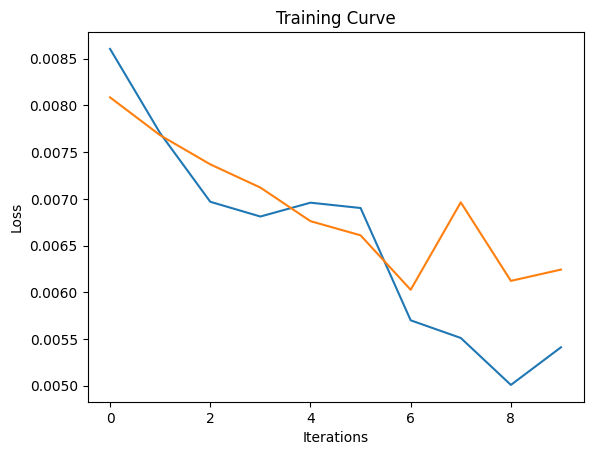

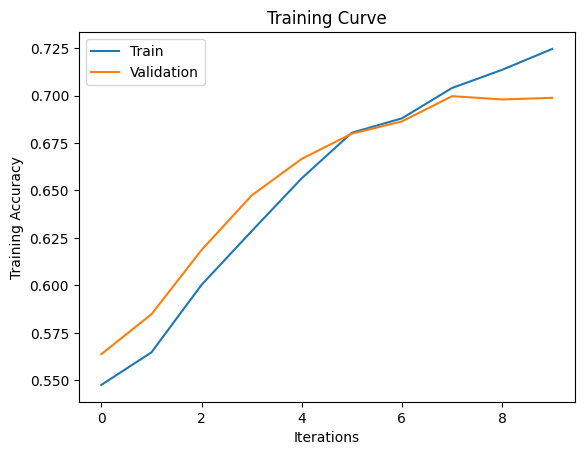

Final Training Accuracy: 0.7245466228759103
Final Validation Accuracy: 0.6988003427592117


In [269]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

In [283]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32, 16)
        self.fc1 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.cbam3(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc1(x)
        return x

Epoch 1: Train acc: 0.3734113951163787 | Validation acc: 0.3718937446443873
Epoch 2: Train acc: 0.5590461230901043 | Validation acc: 0.5689802913453299
Epoch 3: Train acc: 0.5668999000428387 | Validation acc: 0.5912596401028277
Epoch 4: Train acc: 0.5774667999428816 | Validation acc: 0.5882604970008569
Epoch 5: Train acc: 0.5954590889618735 | Validation acc: 0.6019708654670094
Epoch 6: Train acc: 0.6088819077538198 | Validation acc: 0.610968294772922
Epoch 7: Train acc: 0.6331572183349993 | Validation acc: 0.617395029991431
Epoch 8: Train acc: 0.6611452234756533 | Validation acc: 0.6482433590402742
Epoch 9: Train acc: 0.6889904326717121 | Validation acc: 0.6580976863753213
Epoch 10: Train acc: 0.7071255176352992 | Validation acc: 0.6683804627249358
Total time elapsed: 174.45 s


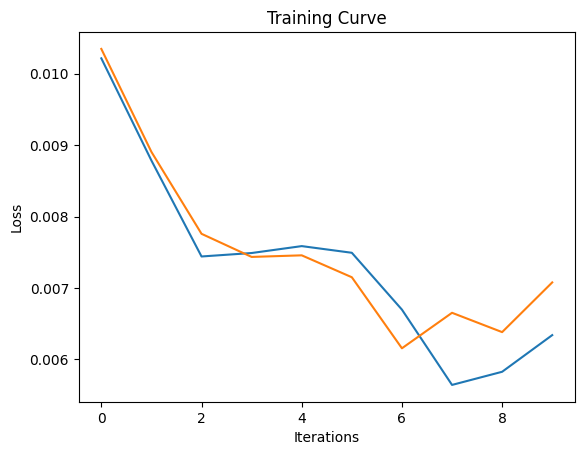

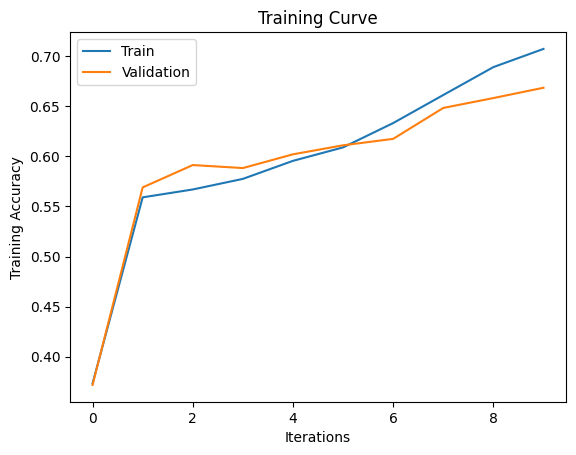

Final Training Accuracy: 0.7071255176352992
Final Validation Accuracy: 0.6683804627249358


In [284]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

In [285]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=1024, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.297158360702556 | Validation acc: 0.30119965724078834
Epoch 2: Train acc: 0.3582750249892903 | Validation acc: 0.35904027420736934
Epoch 3: Train acc: 0.4308153648436384 | Validation acc: 0.4305912596401028
Epoch 4: Train acc: 0.47779523061545054 | Validation acc: 0.4691516709511568
Epoch 5: Train acc: 0.5024989290304155 | Validation acc: 0.5094258783204798


KeyboardInterrupt: 

Epoch 1: Train acc: 0.6004569470227046 | Validation acc: 0.6088260497000857
Epoch 2: Train acc: 0.6360131372269028 | Validation acc: 0.6418166238217652
Epoch 3: Train acc: 0.6644295302013423 | Validation acc: 0.6602399314481576
Epoch 4: Train acc: 0.6877052691703556 | Validation acc: 0.6692373607540703
Epoch 5: Train acc: 0.7046979865771812 | Validation acc: 0.6872322193658955
Epoch 6: Train acc: 0.7121233756961303 | Validation acc: 0.6910882604970009
Epoch 7: Train acc: 0.7331143795516207 | Validation acc: 0.6975149957155099
Epoch 8: Train acc: 0.7425389118949022 | Validation acc: 0.6910882604970009
Epoch 9: Train acc: 0.758103669855776 | Validation acc: 0.6940874035989717
Epoch 10: Train acc: 0.7722404683706983 | Validation acc: 0.6970865467009426
Total time elapsed: 208.99 s


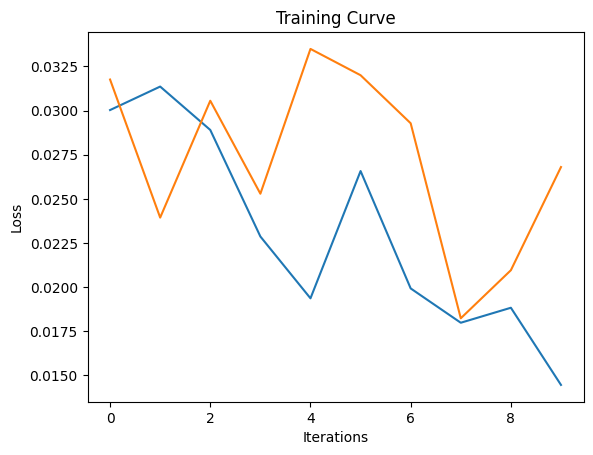

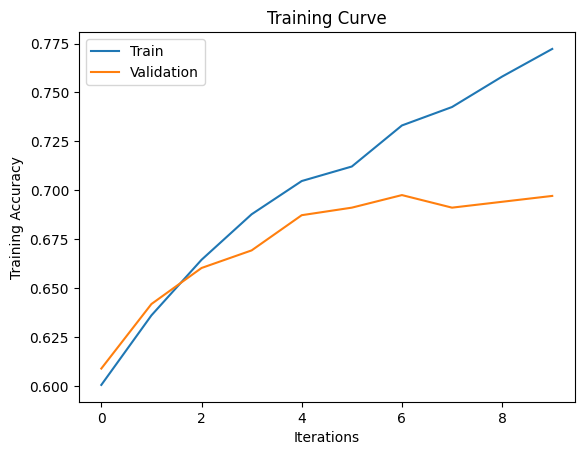

Final Training Accuracy: 0.7722404683706983
Final Validation Accuracy: 0.6970865467009426


In [286]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=10)

In [287]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 5, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32, 16)
        self.fc1 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
       # x = self.cbam3(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.cbam2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc1(x)
        return x

Epoch 1: Train acc: 0.58432100528345 | Validation acc: 0.596401028277635
Epoch 2: Train acc: 0.6108810509781523 | Validation acc: 0.609254498714653
Epoch 3: Train acc: 0.6518634870769671 | Validation acc: 0.6311053984575835
Epoch 4: Train acc: 0.6865629016135941 | Validation acc: 0.6589545844044559
Epoch 5: Train acc: 0.7214051120948165 | Validation acc: 0.6773778920308483
Epoch 6: Train acc: 0.7542481793517064 | Validation acc: 0.6756640959725793
Epoch 7: Train acc: 0.7705269170355562 | Validation acc: 0.675235646958012
Epoch 8: Train acc: 0.7990861059545908 | Validation acc: 0.6765209940017138
Epoch 9: Train acc: 0.7913751249464516 | Validation acc: 0.6713796058269066
Epoch 10: Train acc: 0.8200771098100814 | Validation acc: 0.6850899742930592
Total time elapsed: 167.38 s


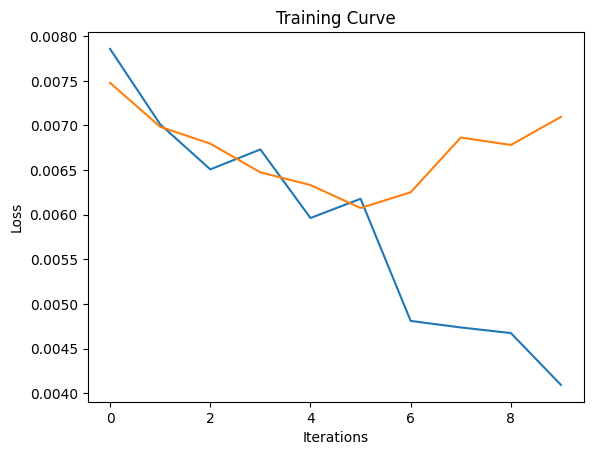

KeyboardInterrupt: 

In [288]:
model_cnn_9 = CNNClassifier() # 7000 training images
train(model_cnn_9, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)